### start

In [37]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_utils.config_validation as ucv
import sage_utils.s3_utils as s3u

import sage_wallet_insights.evaluation_orchestrator as eo
import sage_wallet_insights.model_evaluation as sime

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.wallet_script_modeler as sm
import sage_wallet_modeling.workflow_orchestrator as wo

import script_modeling.custom_transforms as ct
import script_modeling.entry_helpers as h
import script_modeling.single_model_entry as sme
# import script_modeling.temporal_cv_model_entry as tme


# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import wallet_insights.wallet_validation_analysis as wiva
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    ucv, s3u,
    eo, sime,
    wm, sm, wo,
    ct, h, sme,
    wime, wiva,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        # 'config_models',
        'sage_wallet_insights',
        'sage_wallet_modeling',
        'script_modeling',
        # 'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

[15/Aug/25 17:38:48] INFO [utils.export_code:1672] Consolidation complete. All files are saved in temp/sagemaker_code.py
[15/Aug/25 17:38:48] MILESTONE [2672207814.<module>:140] Good morning, let's get to work


# Model Training

## Data Prep

#### load all local data

In [23]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.load_all_training_data()

[15/Aug/25 15:31:36] INFO [workflow_orchestrator.load_all_training_data:100] Auto-detected date_suffixes from config: ['230210', '230312', '230411', '230511', '230610', '230710', '230809', '230908', '231008', '231107', '231207', '240106', '240205', '240306', '240405', '240604', '240803', '241002', '241201', '250130', '250331', '240505', '240704', '240902', '241101', '241231', '250301', '250430', '250530']
[15/Aug/25 15:31:36] MILESTONE [workflow_orchestrator.load_all_training_data:117] <PROD> Loading training data for 29 periods: ['230210', '230312', '230411', '230511', '230610', '230710', '230809', '230908', '231008', '231107', '231207', '240106', '240205', '240306', '240405', '240604', '240803', '241002', '241201', '250130', '250331', '240505', '240704', '240902', '241101', '241231', '250301', '250430', '250530']
[15/Aug/25 15:31:42] INFO [workflow_orchestrator.load_all_training_data:133] Training data loaded successfully: 9,146,310 total rows and 1 offsets for each date_suffix.


#### preprocess and concatenate

In [24]:
results = workflow_orch.preprocess_all_training_data()

[15/Aug/25 15:31:42] INFO [workflow_orchestrator.preprocess_all_training_data:155] Preprocessing 29 date periods...
[15/Aug/25 15:31:42] INFO [wallet_preprocessor.preprocess_training_data:74] Starting preprocessing for SageMaker XGBoost compatibility...
[15/Aug/25 15:31:42] INFO [wallet_preprocessor._handle_missing_values:237] Filled NaN values in 103 columns for x_train.
[15/Aug/25 15:31:42] INFO [wallet_preprocessor._save_preprocessed_df:412] Saved preprocessed train to ../s3_uploads/wallet_training_data_preprocessed/dda_956_importance_v3/230210/train.parquet
[15/Aug/25 15:31:42] INFO [wallet_preprocessor._save_preprocessed_df:412] Saved preprocessed train_y to ../s3_uploads/wallet_training_data_preprocessed/dda_956_importance_v3/230210/train_y.parquet
[15/Aug/25 15:31:42] INFO [wallet_preprocessor.preprocess_training_data:123] Preprocessed train: 27,786 rows × 231 cols.
[15/Aug/25 15:31:42] INFO [wallet_preprocessor._handle_missing_values:237] Filled NaN values in 103 columns for x_

In [25]:
workflow_orch.concatenate_all_preprocessed_data()

[15/Aug/25 15:32:20] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:193] Loading preprocessed training data...
[15/Aug/25 15:32:23] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:196] Beginning concatenation of preprocessed data from Parquet...
[15/Aug/25 15:32:25] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:259] Saved concatenated train_index.parquet with 1191752 rows to ../s3_uploads/wallet_training_data_concatenated/dda_956_importance_v3/train_index.parquet
[15/Aug/25 15:37:55] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:266] Saved concatenated train.csv.gz with 1191752 rows to ../s3_uploads/wallet_training_data_concatenated/dda_956_importance_v3/train.csv.gz
[15/Aug/25 15:37:55] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:259] Saved concatenated eval_index.parquet with 106285 rows to ../s3_uploads/wallet_training_data_concatenated/dda_956_importance_v3/eval_index.parquet
[15/Aug/25 15:38:22] INFO [w

#### inspect features

In [ ]:
local_s3 = sage_wallets_config['training_data']['local_s3_root']
local_dir = sage_wallets_config['training_data']['local_directory']
df = pd.read_csv(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/train.csv.gz')
y_df = pd.read_csv(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/train_y.csv')
with open(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/metadata.json', 'r') as f:
    metadata = json.load(f)

df.columns = metadata['feature_columns']
u.display_full(df.describe().T)

count  \
offset_date                                                 1191751   
balance|total_usd_balance|w1                                1191751   
cluster|k5_cluster_k0                                       1191751   
cluster|k5_cluster_k1                                       1191751   
cluster|k5_cluster_k2                                       1191751   
cluster|k5_cluster_k3                                       1191751   
cluster|k5_cluster_k4                                       1191751   
cw_balance|total_usd_balance|w1                             1191751   
cw_cluster|k5_cluster_k0                                    1191751   
cw_cluster|k5_cluster_k1                                    1191751   
cw_cluster|k5_cluster_k2                                    1191751   
cw_cluster|k5_cluster_k3                                    1191751   
cw_cluster|k5_cluster_k4                                    1191751   
cw_coin_trends|current_holders_in_profit_pct|w1             1191751   
cw_coin_trends|current_holders_in_profit_pct|w2             1191751   
cw_coin_trends|current_holders_in_profit_pct|w3             1191751   
cw_coin_trends|current_holders_in_profit_pct|w4             1191751   
cw_coin_trends|current_holders_in_profit|w1                 1191751   
cw_coin_trends|current_holders_in_profit|w2                 1191751   
cw_coin_trends|current_holders_in_profit|w3                 1191751   
cw_coin_trends|current_holders_in_profit|w4                 1191751   
cw_coin_trends|current_holders_pct_of_lifetime|w1           1191751   
cw_coin_trends|current_holders_pct_of_lifetime|w2           1191751   
cw_coin_trends|current_holders_pct_of_lifetime|w3           1191751   
cw_coin_trends|current_holders_pct_of_lifetime|w4           1191751   
cw_coin_trends|current_holders|w1                           1191751   
cw_coin_trends|current_holders|w2                           1191751   
cw_coin_trends|current_holders|w3                           1191751   
cw_coin_trends|current_holders|w4                           1191751   
cw_coin_trends|days_since_ath|w1                            1191751   
cw_coin_trends|days_since_ath|w2                            1191751   
cw_coin_trends|days_since_ath|w3                            1191751   
cw_coin_trends|days_since_ath|w4                            1191751   
cw_coin_trends|days_since_launch|w1                         1191751   
cw_coin_trends|days_since_launch|w2                         1191751   
cw_coin_trends|days_since_launch|w3                         1191751   
cw_coin_trends|days_since_launch|w4                         1191751   
cw_coin_trends|lifetime_holders|w1                          1191751   
cw_coin_trends|lifetime_holders|w2                          1191751   
cw_coin_trends|lifetime_holders|w3                          1191751   
cw_coin_trends|lifetime_holders|w4                          1191751   
cw_coin_trends|price_pct_of_ath|w1                          1191751   
cw_coin_trends|price_pct_of_ath|w2                          1191751   
cw_coin_trends|price_pct_of_ath|w3                          1191751   
cw_coin_trends|price_pct_of_ath|w4                          1191751   
cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1 1191751   
cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w2 1191751   
cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w3 1191751   
cw_mktcap|end_portfolio_wtd_market_cap/market_cap_unadj|w1  1191751   
cw_mktcap|end_portfolio_wtd_market_cap/market_cap_unadj|w2  1191751   
cw_mktcap|end_portfolio_wtd_market_cap/market_cap_unadj|w3  1191751   
cw_performance|crypto_net_gain/crypto_inflows/winsorized|w1 1191751   
cw_performance|crypto_net_gain/crypto_inflows/winsorized|w2 1191751   
cw_performance|crypto_net_gain/crypto_inflows/winsorized|w3 1191751   
cw_performance|crypto_net_gain/crypto_inflows/winsorized|w4 1191751   
cw_scenario|ideal/relative_cash_buys/pct_rank|w1            1191751   
cw_scenario|ide

In [43]:
df.shape

(1191751, 231)

In [44]:
y_df.columns

Index(['average_transaction', 'crypto_cash_buys', 'crypto_cash_sells',
       'crypto_inflows', 'crypto_net_cash_flows', 'crypto_net_flows',
       'crypto_net_flows/crypto_inflows/base',
       'crypto_net_flows/crypto_inflows/rank',
       'crypto_net_flows/crypto_inflows/winsorized',
       'crypto_net_flows/max_investment/base',
       'crypto_net_flows/max_investment/rank',
       'crypto_net_flows/max_investment/winsorized', 'crypto_net_gain',
       'crypto_net_gain/crypto_inflows/base',
       'crypto_net_gain/crypto_inflows/rank',
       'crypto_net_gain/crypto_inflows/winsorized',
       'crypto_net_gain/max_investment/base',
       'crypto_net_gain/max_investment/rank',
       'crypto_net_gain/max_investment/winsorized', 'crypto_outflows',
       'cw_average_transaction', 'cw_coin_return', 'cw_coin_return_rank',
       'cw_coin_return_winsorized', 'cw_crypto_cash_buys',
       'cw_crypto_cash_sells', 'cw_crypto_inflows', 'cw_crypto_net_cash_flows',
       'cw_crypto_net_flow

#### upload

In [26]:
concat_uris = workflow_orch.upload_concatenated_training_data(
    overwrite_existing=True,
    # splits=['val']
)

[15/Aug/25 15:46:12] INFO [workflow_orchestrator.upload_concatenated_training_data:379] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[15/Aug/25 15:46:12] INFO [workflow_orchestrator.upload_concatenated_training_data:382] Uploading concatenated splits in parallel with 4 threads...
[15/Aug/25 15:46:13] INFO [workflow_orchestrator._upload_split:403] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-956-importan-v3/train.csv.gz', proceeding with upload...
[15/Aug/25 15:46:13] INFO [workflow_orchestrator._upload_split:403] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-956-importan-v3/val.csv.gz', proceeding with upload...
[15/Aug/25 15:46:13] INFO [workflow_orchestrator._upload_split:403] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-956-importan-v3/test.csv.gz', proceeding with upload...
[15/Aug/25 15:46:13] INF

## Epoch Shifts Sequence

#### train all epoch shifts

In [27]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_all_epoch_shift_models(concat_uris)

[15/Aug/25 15:46:48] INFO [workflow_orchestrator.upload_concatenated_training_data:379] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[15/Aug/25 15:46:48] INFO [workflow_orchestrator.upload_concatenated_training_data:382] Uploading concatenated splits in parallel with 4 threads...
[15/Aug/25 15:46:48] INFO [workflow_orchestrator._upload_split:396] File exists, skipping upload of concatenated split 'train': training-data-concatenated/dda-956-importan-v3/train.csv.gz
[15/Aug/25 15:46:48] INFO [workflow_orchestrator._upload_split:396] File exists, skipping upload of concatenated split 'eval': training-data-concatenated/dda-956-importan-v3/eval.csv.gz
[15/Aug/25 15:46:48] INFO [workflow_orchestrator._upload_split:396] File exists, skipping upload of concatenated split 'test': training-data-concatenated/dda-956-importan-v3/test.csv.gz
[15/Aug/25 15:46:48] INFO [workflow_orchestrator._upload_split:396] Fi

2025-08-15 22:46:50 Starting - Starting the training job2025-08-15 22:46:50 Starting - Starting the training job2025-08-15 22:46:50 Starting - Starting the training job2025-08-15 22:46:50 Starting - Starting the training job....2025-08-15 22:46:53 Starting - Starting the training job.2025-08-15 22:46:55 Starting - Starting the training job.2025-08-15 22:46:56 Starting - Starting the training job...............
2025-08-15 22:47:23 Downloading - Downloading input data
2025-08-15 22:47:05 Starting - Preparing the instances for training
2025-08-15 22:47:24 Downloading - Downloading input data
2025-08-15 22:47:23 Downloading - Downloading input data....
2025-08-15 22:47:26 Downloading - Downloading input data.
2025-08-15 22:47:26 Downloading - Downloading input data.
2025-08-15 22:47:30 Downloading - Downloading input data...............
2025-08-15 22:47:48 Downloading - Downloading the training image
2025-08-15 22:47:49 Downloading - Downloading the training image
2025-08-15 22:47:26 Downl

[15/Aug/25 15:51:43] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh180/wscr-dda-956--sh180-0815-154648/output/model.tar.gz
[15/Aug/25 15:51:43] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=180
[15/Aug/25 15:51:43] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh60/wscr-dda-956--sh60-0815-154648/output/model.tar.gz
[15/Aug/25 15:51:43] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=60
[15/Aug/25 15:51:43] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh0/wscr-dda-956--sh0-0815-154648/

Training seconds: 239
Billable seconds: 239


[15/Aug/25 15:51:46] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh120/wscr-dda-956--sh120-0815-154648/output/model.tar.gz
[15/Aug/25 15:51:46] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=120


[152]#011eval-aucpr:0.43196
[153]#011eval-aucpr:0.43191
[154]#011eval-aucpr:0.43185
[155]#011eval-aucpr:0.43121
[156]#011eval-aucpr:0.43102
[157]#011eval-aucpr:0.43156
[158]#011eval-aucpr:0.43020
[159]#011eval-aucpr:0.43023
[160]#011eval-aucpr:0.42997
[161]#011eval-aucpr:0.42994
[162]#011eval-aucpr:0.43018
[163]#011eval-aucpr:0.43026
[164]#011eval-aucpr:0.43023
[165]#011eval-aucpr:0.43079
[189]#011eval-aucpr:0.47991
[190]#011eval-aucpr:0.48027
[191]#011eval-aucpr:0.48026
[192]#011eval-aucpr:0.48041
[193]#011eval-aucpr:0.48015
[194]#011eval-aucpr:0.47985
[195]#011eval-aucpr:0.48025
[196]#011eval-aucpr:0.48044
[197]#011eval-aucpr:0.48005
[198]#011eval-aucpr:0.47970
[199]#011eval-aucpr:0.47968
[200]#011eval-aucpr:0.48001
[201]#011eval-aucpr:0.48024
[202]#011eval-aucpr:0.48022
[203]#011eval-aucpr:0.48046
[204]#011eval-aucpr:0.48048
[205]#011eval-aucpr:0.48042
[206]#011eval-aucpr:0.47996
[207]#011eval-aucpr:0.47996
[208]#011eval-aucpr:0.48032
[209]#011eval-aucpr:0.48092
[210]#011eval-aucpr:

[15/Aug/25 15:52:19] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh300/wscr-dda-956--sh300-0815-154648/output/model.tar.gz
[15/Aug/25 15:52:19] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=300


Training seconds: 270
Billable seconds: 270


[15/Aug/25 15:52:20] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh360/wscr-dda-956--sh360-0815-154648/output/model.tar.gz
[15/Aug/25 15:52:20] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=360


[245]#011eval-aucpr:0.48274
[246]#011eval-aucpr:0.48239
[247]#011eval-aucpr:0.48252
[248]#011eval-aucpr:0.48226
[249]#011eval-aucpr:0.48196
[250]#011eval-aucpr:0.48178
[251]#011eval-aucpr:0.48171
[252]#011eval-aucpr:0.48164
[253]#011eval-aucpr:0.48156
[254]#011eval-aucpr:0.48130
[255]#011eval-aucpr:0.48141
[256]#011eval-aucpr:0.48127
[257]#011eval-aucpr:0.48128
[258]#011eval-aucpr:0.48152
[259]#011eval-aucpr:0.48168
[260]#011eval-aucpr:0.48176
[261]#011eval-aucpr:0.48175
[262]#011eval-aucpr:0.48167

2025-08-15 22:52:33 Uploading - Uploading generated training model
2025-08-15 22:52:33 Completed - Training job completed
[263]#011eval-aucpr:0.48195
[264]#011eval-aucpr:0.48196
Training seconds: 310
Billable seconds: 310


[15/Aug/25 15:52:45] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh240/wscr-dda-956--sh240-0815-154648/output/model.tar.gz
[15/Aug/25 15:52:45] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:505] Successfully completed training for epoch_shift=240
[15/Aug/25 15:52:45] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:515] Epoch shift training complete: 7/7 models successful


#### predict all epoch_shifts

In [28]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

workflow_orch.predict_all_epoch_shifts(overwrite_existing=True)

[15/Aug/25 15:52:46] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:691] Starting predictions for 7 epoch shifts using 15 threads...
[15/Aug/25 15:52:46] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0815-154648): s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh60/wscr-dda-956--sh60-0815-154648/output/model.tar.gz
[15/Aug/25 15:52:46] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0815-154648): s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh120/wscr-dda-956--sh120-0815-154648/output/model.tar.gz
[15/Aug/25 15:52:46] INFO [wallet_modeler.predict_with_local_transform:389] Starting local transform for test dataset...
[15/Aug/25 15:52:46] INFO [wallet_modeler.predict_with_local_transform:389] Starting local transform for val dataset...
[15/Aug/25 15:52:46] INFO [wallet_modeler.predict_with_local_transform:389] Starting local transform for test dataset...


.......

[15/Aug/25 15:58:11] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[15/Aug/25 15:58:12] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh240-0815-154648
[15/Aug/25 15:58:12] INFO [wallet_modeler._execute_batch_transform:866] Starting batch transform job: wallet-scoring-sh240-155812-concat-test
[15/Aug/25 15:58:12] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh240-155812-concat-test


...............................................................................................................................................................................................................................................................................................................................................................................................................!

[15/Aug/25 16:03:03] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh60/wallet-scoring-sh60-155802-concat-test/test-filtered-20250815-155310.csv.gz.out



.

[15/Aug/25 16:03:04] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh60/test.csv.out.
[15/Aug/25 16:03:04] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[15/Aug/25 16:03:04] INFO [wallet_modeler.None:359] (10m17s) Completed predict_with_local_transform.


!

[15/Aug/25 16:03:06] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh360/wallet-scoring-sh360-155805-concat-test/test-filtered-20250815-155312.csv.gz.out



.

[15/Aug/25 16:03:06] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh360/test.csv.out.
[15/Aug/25 16:03:06] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[15/Aug/25 16:03:06] INFO [wallet_modeler.None:359] (10m20s) Completed predict_with_local_transform.


!

[15/Aug/25 16:03:06] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh300/wallet-scoring-sh300-155800-concat-test/test-filtered-20250815-155310.csv.gz.out



.

[15/Aug/25 16:03:07] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh300/test.csv.out.
[15/Aug/25 16:03:07] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[15/Aug/25 16:03:07] INFO [wallet_modeler.None:359] (10m21s) Completed predict_with_local_transform.


!

[15/Aug/25 16:03:08] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh240/wallet-scoring-sh240-155812-concat-test/test-filtered-20250815-155311.csv.gz.out



.

[15/Aug/25 16:03:08] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh240/test.csv.out.
[15/Aug/25 16:03:08] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[15/Aug/25 16:03:09] INFO [wallet_modeler.None:359] (10m22s) Completed predict_with_local_transform.


.......!

[15/Aug/25 16:03:22] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh180/wallet-scoring-sh180-155806-concat-test/test-filtered-20250815-155312.csv.gz.out


[15/Aug/25 16:03:23] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh180/test.csv.out.
[15/Aug/25 16:03:23] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[15/Aug/25 16:03:23] INFO [wallet_modeler.None:359] (10m36s) Completed predict_with_local_transform.


..!

[15/Aug/25 16:03:29] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh0/wallet-scoring-sh0-155803-concat-test/test-filtered-20250815-155310.csv.gz.out


[15/Aug/25 16:03:29] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh0/test.csv.out.
[15/Aug/25 16:03:29] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[15/Aug/25 16:03:29] INFO [wallet_modeler.None:359] (10m43s) Completed predict_with_local_transform.


..!

[15/Aug/25 16:03:42] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh120/wallet-scoring-sh120-155805-concat-test/test-filtered-20250815-155312.csv.gz.out


[15/Aug/25 16:03:43] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh120/test.csv.out.
[15/Aug/25 16:03:43] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for test
[15/Aug/25 16:03:43] INFO [wallet_modeler.None:359] (10m56s) Completed predict_with_local_transform.
[15/Aug/25 16:13:01] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[15/Aug/25 16:13:01] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh180-0815-154648
[15/Aug/25 16:13:02] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh180-0815-154648
[15/Aug/25 16:13:02] INFO [wallet_modeler._execute_batch_transform:866] Starting batch transform job: wallet-scoring-sh180-161302-concat-val
[15/Aug/25 16:13:02] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh180-161302-concat-val


.........

[15/Aug/25 16:13:50] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[15/Aug/25 16:13:50] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh120-0815-154648
[15/Aug/25 16:13:50] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh120-0815-154648
[15/Aug/25 16:13:50] INFO [wallet_modeler._execute_batch_transform:866] Starting batch transform job: wallet-scoring-sh120-161350-concat-val
[15/Aug/25 16:13:50] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh120-161350-concat-val
[15/Aug/25 16:13:52] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[15/Aug/25 16:13:52] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh0-0815-154648
[15/Aug/25 16:13:52] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[15/Aug/25 16:13:52] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh300-0815-154648
[15/Aug/25 16:13:52] 

.

[15/Aug/25 16:13:54] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[15/Aug/25 16:13:54] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh240-0815-154648
[15/Aug/25 16:13:54] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[15/Aug/25 16:13:54] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh60-0815-154648
[15/Aug/25 16:13:55] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh240-0815-154648
[15/Aug/25 16:13:55] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh60-0815-154648
[15/Aug/25 16:13:55] INFO [wallet_modeler._execute_batch_transform:866] Starting batch transform job: wallet-scoring-sh240-161355-concat-val
[15/Aug/25 16:13:55] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh240-161355-concat-val
[15/Aug/25 16:13:55] INFO [wallet_modeler._execute_batch_transform:866] Starting batch transform job: wallet-s

...

[15/Aug/25 16:13:58] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[15/Aug/25 16:13:58] INFO [session.submit:4105] Creating model with name: wscr-dda-956--sh360-0815-154648


.

[15/Aug/25 16:13:59] WARNING [session.submit:4116] Using already existing model: wscr-dda-956--sh360-0815-154648
[15/Aug/25 16:13:59] INFO [wallet_modeler._execute_batch_transform:866] Starting batch transform job: wallet-scoring-sh360-161359-concat-val
[15/Aug/25 16:13:59] INFO [session.submit:3962] Creating transform job with name: wallet-scoring-sh360-161359-concat-val


............................................................................................................................................................................................................................................................................................................................................................................................................................................................!

[15/Aug/25 16:19:23] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh180/wallet-scoring-sh180-161302-concat-val/val-filtered-20250815-155705.csv.gz.out



..

[15/Aug/25 16:19:23] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh180/val.csv.out.
[15/Aug/25 16:19:23] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for val
[15/Aug/25 16:19:23] INFO [wallet_modeler.None:359] (26m37s) Completed predict_with_local_transform.
[15/Aug/25 16:19:23] INFO [wallet_modeler.None:433] (26m37s) Completed batch_predict_test_and_val.
[15/Aug/25 16:19:23] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:717] ✓ Completed predictions for epoch_shift=180


.........................................!

[15/Aug/25 16:19:59] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh300/wallet-scoring-sh300-161353-concat-val/val-filtered-20250815-155735.csv.gz.out



.

[15/Aug/25 16:20:00] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh300/val.csv.out.
[15/Aug/25 16:20:00] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for val
[15/Aug/25 16:20:00] INFO [wallet_modeler.None:359] (27m13s) Completed predict_with_local_transform.
[15/Aug/25 16:20:00] INFO [wallet_modeler.None:433] (27m13s) Completed batch_predict_test_and_val.
[15/Aug/25 16:20:00] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:717] ✓ Completed predictions for epoch_shift=300


..!

[15/Aug/25 16:20:01] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh120/wallet-scoring-sh120-161350-concat-val/val-filtered-20250815-155732.csv.gz.out


[15/Aug/25 16:20:02] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh120/val.csv.out.
[15/Aug/25 16:20:02] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for val
[15/Aug/25 16:20:02] INFO [wallet_modeler.None:359] (27m15s) Completed predict_with_local_transform.
[15/Aug/25 16:20:02] INFO [wallet_modeler.None:433] (27m15s) Completed batch_predict_test_and_val.
[15/Aug/25 16:20:02] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:717] ✓ Completed predictions for epoch_shift=120


...!

[15/Aug/25 16:20:05] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh240/wallet-scoring-sh240-161355-concat-val/val-filtered-20250815-155737.csv.gz.out


[15/Aug/25 16:20:06] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh240/val.csv.out.
[15/Aug/25 16:20:06] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for val
[15/Aug/25 16:20:06] INFO [wallet_modeler.None:359] (27m20s) Completed predict_with_local_transform.
[15/Aug/25 16:20:06] INFO [wallet_modeler.None:433] (27m20s) Completed batch_predict_test_and_val.
[15/Aug/25 16:20:06] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:717] ✓ Completed predictions for epoch_shift=240


.!

[15/Aug/25 16:20:10] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh360/wallet-scoring-sh360-161359-concat-val/val-filtered-20250815-155736.csv.gz.out


[15/Aug/25 16:20:11] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh360/val.csv.out.
[15/Aug/25 16:20:11] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for val
[15/Aug/25 16:20:11] INFO [wallet_modeler.None:359] (27m24s) Completed predict_with_local_transform.


.

[15/Aug/25 16:20:11] INFO [wallet_modeler.None:433] (27m24s) Completed batch_predict_test_and_val.
[15/Aug/25 16:20:11] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:717] ✓ Completed predictions for epoch_shift=360


.....!

[15/Aug/25 16:20:26] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh60/wallet-scoring-sh60-161355-concat-val/val-filtered-20250815-155740.csv.gz.out



!

[15/Aug/25 16:20:28] INFO [wallet_modeler._execute_batch_transform:885] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh0/wallet-scoring-sh0-161352-concat-val/val-filtered-20250815-155736.csv.gz.out


[15/Aug/25 16:20:29] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh0/val.csv.out.
[15/Aug/25 16:20:29] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for val
[15/Aug/25 16:20:29] INFO [wallet_modeler.None:359] (27m43s) Completed predict_with_local_transform.
[15/Aug/25 16:20:29] INFO [wallet_modeler.None:433] (27m43s) Completed batch_predict_test_and_val.
[15/Aug/25 16:20:29] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:717] ✓ Completed predictions for epoch_shift=0
[15/Aug/25 16:20:31] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_956_importance_v3/sh60/val.csv.out.
[15/Aug/25 16:20:31] INFO [wallet_modeler.predict_with_local_transform:428] Local transform prediction completed for val
[15/Aug/25 16:20:31] INFO [wallet_modeler.None:359] (27m44s) Completed predict_with_local_transform.
[15/Aug/25 16:20:31] INFO [wallet_

{180: {'test': {'transform_job_name': 'wallet-scoring-sh180-155806-concat-test',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh180/wallet-scoring-sh180-155806-concat-test/test-filtered-20250815-155312.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/temp-transform-data/dda-956-importan-v3/sh180/test-filtered-20250815-155312.csv.gz'},
  'val': {'transform_job_name': 'wallet-scoring-sh180-161302-concat-val',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-956-importan-v3/sh180/wallet-scoring-sh180-161302-concat-val/val-filtered-20250815-155705.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/temp-transform-data/dda-956-importan-v3/sh180/val-filtered-20250815-155705.csv.gz'},
  'model_uri': 's3://wallet-script-models/model-outputs/dda-956-importan-v3/sh180/wscr-dda-956--sh180-0815-154648/output/model.tar.gz',
  'training_job_name': 'wscr-dda-956--sh180-0815-154648',
  'epoch_shift': 180},
 

#### evaluate importances

In [29]:
# Import and reload modules (your existing pattern)
[importlib.reload(module) for module in modules]

# Load configs (your existing pattern)
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Create evaluation orchestrator
import sage_wallet_insights.evaluation_orchestrator as eo
eval_orch = eo.EvaluationOrchestrator(sage_wallets_config, sage_wallets_modeling_config)
complete_importance_data = eval_orch.generate_all_feature_importances()

[15/Aug/25 16:20:31] MILESTONE [evaluation_orchestrator.generate_all_feature_importances:84] Generating feature importances for 7 epoch shifts...
[15/Aug/25 16:20:31] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0815-154648): s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh60/wscr-dda-956--sh60-0815-154648/output/model.tar.gz
[15/Aug/25 16:20:31] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0815-154648): s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh180/wscr-dda-956--sh180-0815-154648/output/model.tar.gz
[15/Aug/25 16:20:31] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0815-154648): s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh120/wscr-dda-956--sh120-0815-154648/output/model.tar.gz
[15/Aug/25 16:20:31] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timesta

In [30]:
# w regularization
feature_categories_filter = [
    # 'cw_coin_trends',
    # 'macro',
    # 'scenario'
    # 'timing',
    # 'trading'
]

feature_names_filter = [
    # 'price_sma_2',
    # 'price_rsi_5',
    # etc.
]

groups = [
    'feature_category',
    # 'feature_name',
    # 'feature_comparison',
    # 'feature_aggregation',
    # 'training_segment',
    # 'feature'
]

# NEW: Analyze across all epoch shifts automatically
all_importance_stats = eval_orch.filter_and_aggregate_importances(
    feature_categories_filter=feature_categories_filter,
    # feature_names_filter=feature_names_filter,
    groups=groups,
    complete_df=complete_importance_data
)

# View results
u.display_full(all_importance_stats.sort_values(by='pct_max',ascending=False))

[15/Aug/25 16:20:32] INFO [evaluation_orchestrator.filter_and_aggregate_importances:229] Filtered importance analysis: 18 feature groups across 7 models


column_count  pct_mean  pct_median  pct_min  pct_max  \
feature_category                                                         
macro                       32     0.623      0.5934    0.517   0.8085   
cw_coin_trends              32    0.1687      0.1908   0.0828    0.226   
cw_transfers                16    0.0314      0.0184   0.0092   0.0966   
cw_scenario                 32     0.036       0.038   0.0205   0.0464   
cw_mktcap                    6    0.0273      0.0262   0.0113   0.0427   
timing                      33    0.0286      0.0283   0.0172   0.0363   
transfers                   20    0.0209      0.0219   0.0124   0.0264   
cw_cluster                   5    0.0059      0.0021   0.0012   0.0227   
scenario                    16    0.0141       0.015   0.0087   0.0176   
cw_performance               4    0.0092      0.0096   0.0046   0.0139   
trading                      6    0.0088      0.0095   0.0055   0.0116   
cw_trading                   3    0.0078      0.0078   0.0048   0.0106   
cw_timing                   10    0.0077       0.007   0.0052   0.0099   
performance                  4    0.0043      0.0042   0.0025   0.0079   
mktcap                       4    0.0032       0.003   0.0021    0.004   
cluster                      5    0.0009      0.0008        0   0.0018   
cw_balance                   1    0.0011      0.0011   0.0007   0.0016   
balance                      1     0.001       0.001   0.0009   0.0013   

                  pct_std  total_importance_sum  importance_mean  
feature_category                                                  
macro              0.0979              85546.43         12220.92  
cw_coin_trends     0.0487              21733.23          3104.75  
cw_transfers         0.03               4002.84           571.83  
cw_scenario        0.0093               4650.73           664.39  
cw_mktcap          0.0126               3447.52            492.5  
timing              0.006               3708.03           529.72  
transfers          0.0051                2674.9           382.13  
cw_cluster         0.0077                741.91           105.99  
scenario           0.0028               1838.78           262.68  
cw_performance     0.0037               1188.06           169.72  
trading             0.002               1144.47            163.5  
cw_trading          0.002               1015.87           145.12  
cw_timing          0.0018                990.33           141.48  
performance        0.0017                579.66            82.81  
mktcap             0.0007                409.95            58.56  
cluster            0.0008                120.91            17.27  
cw_balance         0.0003                147.28            21.04  
balance            0.0002                136.91            19.56

#### evaluate all epoch shifts

In [35]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


eval_orch = eo.EvaluationOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = eval_orch.build_all_epoch_shift_evaluators()


[15/Aug/25 17:23:54] MILESTONE [evaluation_orchestrator.build_all_epoch_shift_evaluators:249] Building evaluators for 7 epoch shifts using 8 threads...
[15/Aug/25 17:23:54] INFO [evaluation_orchestrator.build_all_epoch_shift_evaluators:254] Loading shared target and feature data...
[15/Aug/25 17:24:15] INFO [evaluation_orchestrator.build_all_epoch_shift_evaluators:258] Target and feature data loaded successfully.
[15/Aug/25 17:24:15] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0815-154648): s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh240/wscr-dda-956--sh240-0815-154648/output/model.tar.gz
[15/Aug/25 17:24:15] INFO [wallet_modeler.load_existing_model:230] Loaded most recent script-mode model (timestamp: 0815-154648): s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh0/wscr-dda-956--sh0-0815-154648/output/model.tar.gz
[15/Aug/25 17:24:15] INFO [wallet_modeler.load_existing_model:230] Loaded most recent scrip

Unique offset_date values in data: [1140.0, 1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0]
Target offset_days after 0 shift: [1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560]
Starting with 142,879 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 7,849,696
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 17,371 rows
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 6
  Max: 993,646,016
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 49,779 rows
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 349
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 51,167 rows
Row filtering complete: 89,086 rows removed (62.4%), 53,793 row

[15/Aug/25 17:26:18] INFO [model_evaluation.None:387] (1m36s) Completed _apply_custom_transforms_to_concatenated_data.
[15/Aug/25 17:26:18] INFO [model_evaluation.None:387] (54.2s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 232,762 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 12,657,555
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 34,310 rows
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3
  Max: 927,281,984
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 78,010 rows
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 346
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 71,415 rows
Row filtering complete: 138,236 rows removed (59.4%), 94,526 rows remaining
Starting with 171,623 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 14,063,788
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 33,197 rows
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3,253
  Max: 929,659,456
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_

[15/Aug/25 17:26:23] INFO [model_evaluation.None:36] (1m41s) Completed create_concatenated_sagemaker_evaluator.
[15/Aug/25 17:26:23] MILESTONE [evaluation_orchestrator.build_all_epoch_shift_evaluators:283] ✓ Built evaluator for epoch_shift=0
[15/Aug/25 17:26:23] INFO [model_evaluation.None:36] (59.3s) Completed create_concatenated_sagemaker_evaluator.
[15/Aug/25 17:26:23] MILESTONE [evaluation_orchestrator.build_all_epoch_shift_evaluators:283] ✓ Built evaluator for epoch_shift=240


Unique offset_date values in data: [1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after 180 shift: [1770, 1800]


[15/Aug/25 17:26:27] INFO [model_evaluation.None:387] (45.0s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 283,340 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 14,403,229
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 33,588 rows
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 3,022
  Max: 980,591,168
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 78,307 rows
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 342
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 89,337 rows
Row filtering complete: 156,519 rows removed (55.2%), 126,821 rows remaining
Unique offset_date values in data: [1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after 300 shift: [1890, 1920]
Unique offset_date values in data: [1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset

[15/Aug/25 17:26:28] INFO [model_evaluation.None:387] (38.9s) Completed _apply_custom_transforms_to_concatenated_data.


Starting with 119,347 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 9,878,339
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 30,759 rows
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: 2,753
  Max: 956,419,840
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 5000000: removed 35,061 rows
Column stats for trading|unique_coins_traded|all_windows:
  Min: 3
  Max: 345
Filter 'trading|unique_coins_traded|all_windows' min 5: removed 39,377 rows
Row filtering complete: 75,608 rows removed (63.4%), 43,739 rows remaining
Starting with 176,272 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
Starting with 251,656 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Min: 0
  Max: 14,711,453
  Max: 10,752,532
Filter 'cw_balance|total_usd_balance|w1' min 1000: removed 40,937 rows
Column stats for cw_mktcap|end_por

[15/Aug/25 17:26:29] INFO [model_evaluation.None:387] (38.9s) Completed _apply_custom_transforms_to_concatenated_data.
[15/Aug/25 17:26:29] INFO [model_evaluation.None:387] (39.0s) Completed _apply_custom_transforms_to_concatenated_data.
[15/Aug/25 17:26:29] INFO [model_evaluation.None:387] (39.0s) Completed _apply_custom_transforms_to_concatenated_data.
[15/Aug/25 17:26:32] INFO [model_evaluation.None:36] (50.0s) Completed create_concatenated_sagemaker_evaluator.
[15/Aug/25 17:26:32] MILESTONE [evaluation_orchestrator.build_all_epoch_shift_evaluators:283] ✓ Built evaluator for epoch_shift=180
[15/Aug/25 17:26:32] INFO [model_evaluation.None:36] (43.0s) Completed create_concatenated_sagemaker_evaluator.
[15/Aug/25 17:26:32] MILESTONE [evaluation_orchestrator.build_all_epoch_shift_evaluators:283] ✓ Built evaluator for epoch_shift=300
[15/Aug/25 17:26:33] INFO [model_evaluation.None:36] (43.1s) Completed create_concatenated_sagemaker_evaluator.
[15/Aug/25 17:26:33] MILESTONE [evaluation_

[15/Aug/25 17:26:33] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 17:26:33] WARNING [1138767417.<module>:5]                 0: 2024-06-04
[15/Aug/25 17:26:33] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 17:26:33] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh0/wscr-dda-956--sh0-0815-154648/output/model.tar.gz
Test Samples:             53,793
Val Positive Samples:     4,407 (4.7%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.471  |  0.788
Val Accuracy:               0.924  |  0.860
Val Precision:              0.037  |  0.517
Val Recall:                 0.025  |  0.478
Val F1 Score:               0.030  |  0.497

Validation Retu

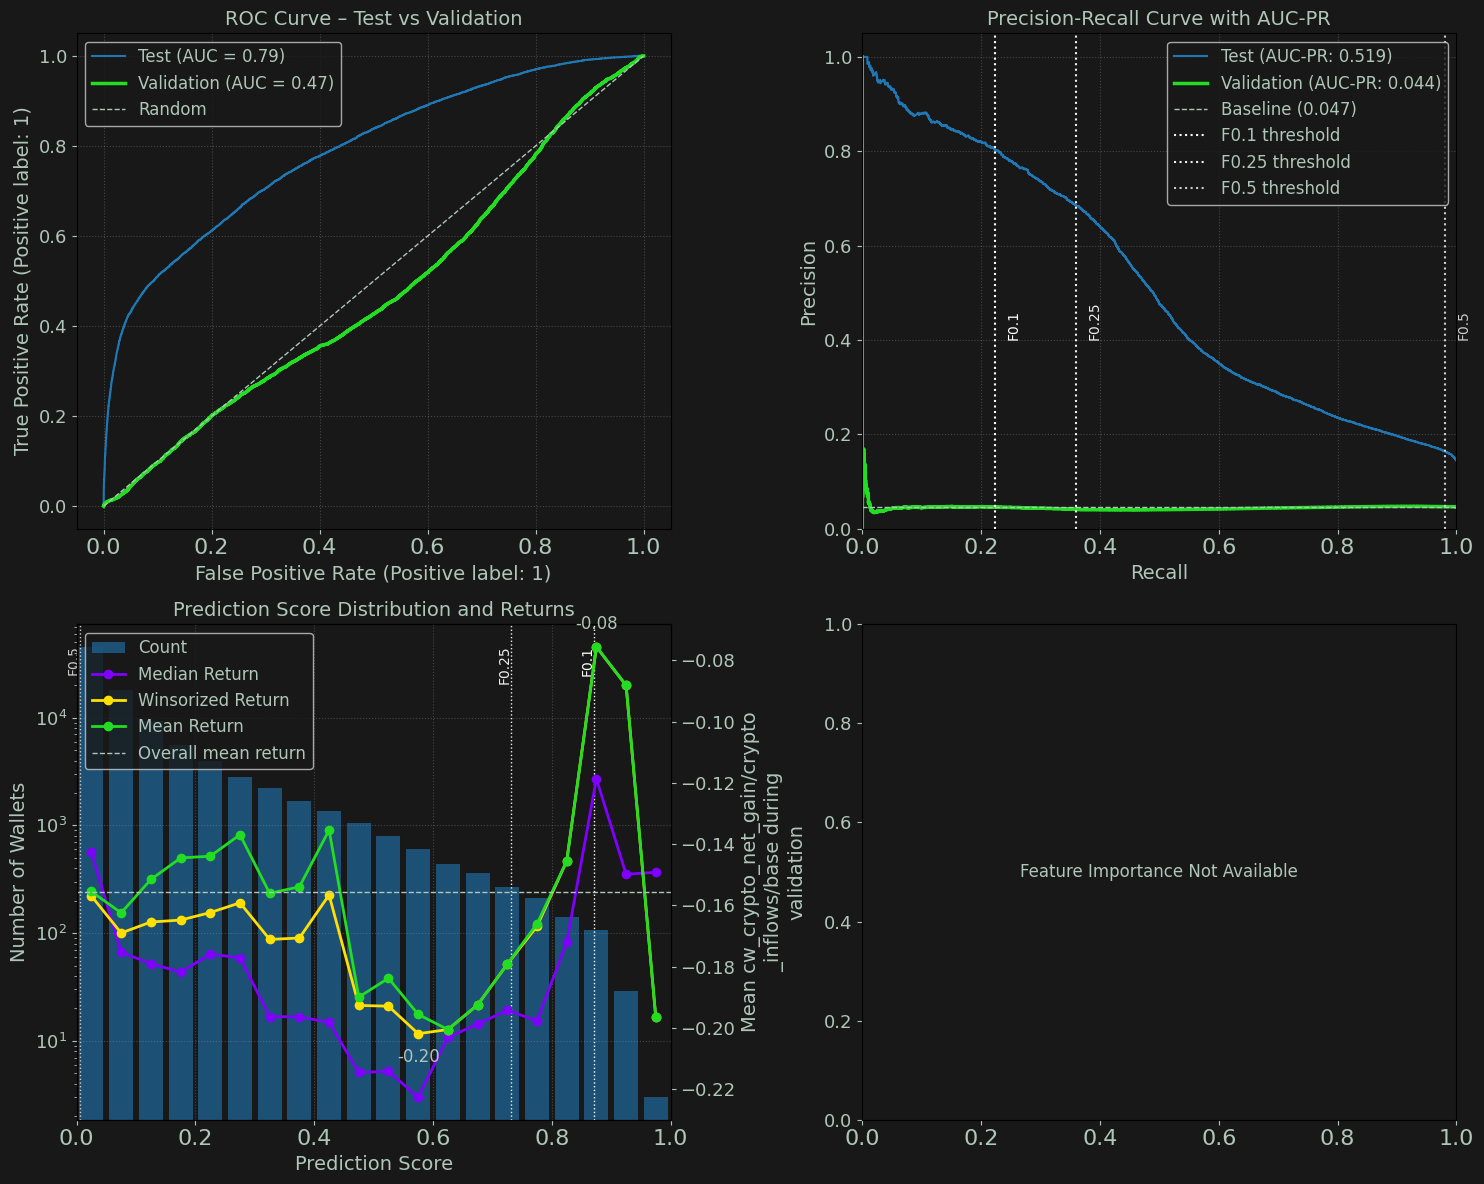

[15/Aug/25 17:26:33] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 17:26:33] WARNING [1138767417.<module>:5]                 60: 2024-08-03
[15/Aug/25 17:26:33] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 17:26:33] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh60/wscr-dda-956--sh60-0815-154648/output/model.tar.gz
Test Samples:             64,508
Val Positive Samples:     11,787 (17.1%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.623  |  0.792
Val Accuracy:               0.829  |  0.883
Val Precision:              0.461  |  0.536
Val Recall:                 0.011  |  0.451
Val F1 Score:               0.021  |  0.490

Validation

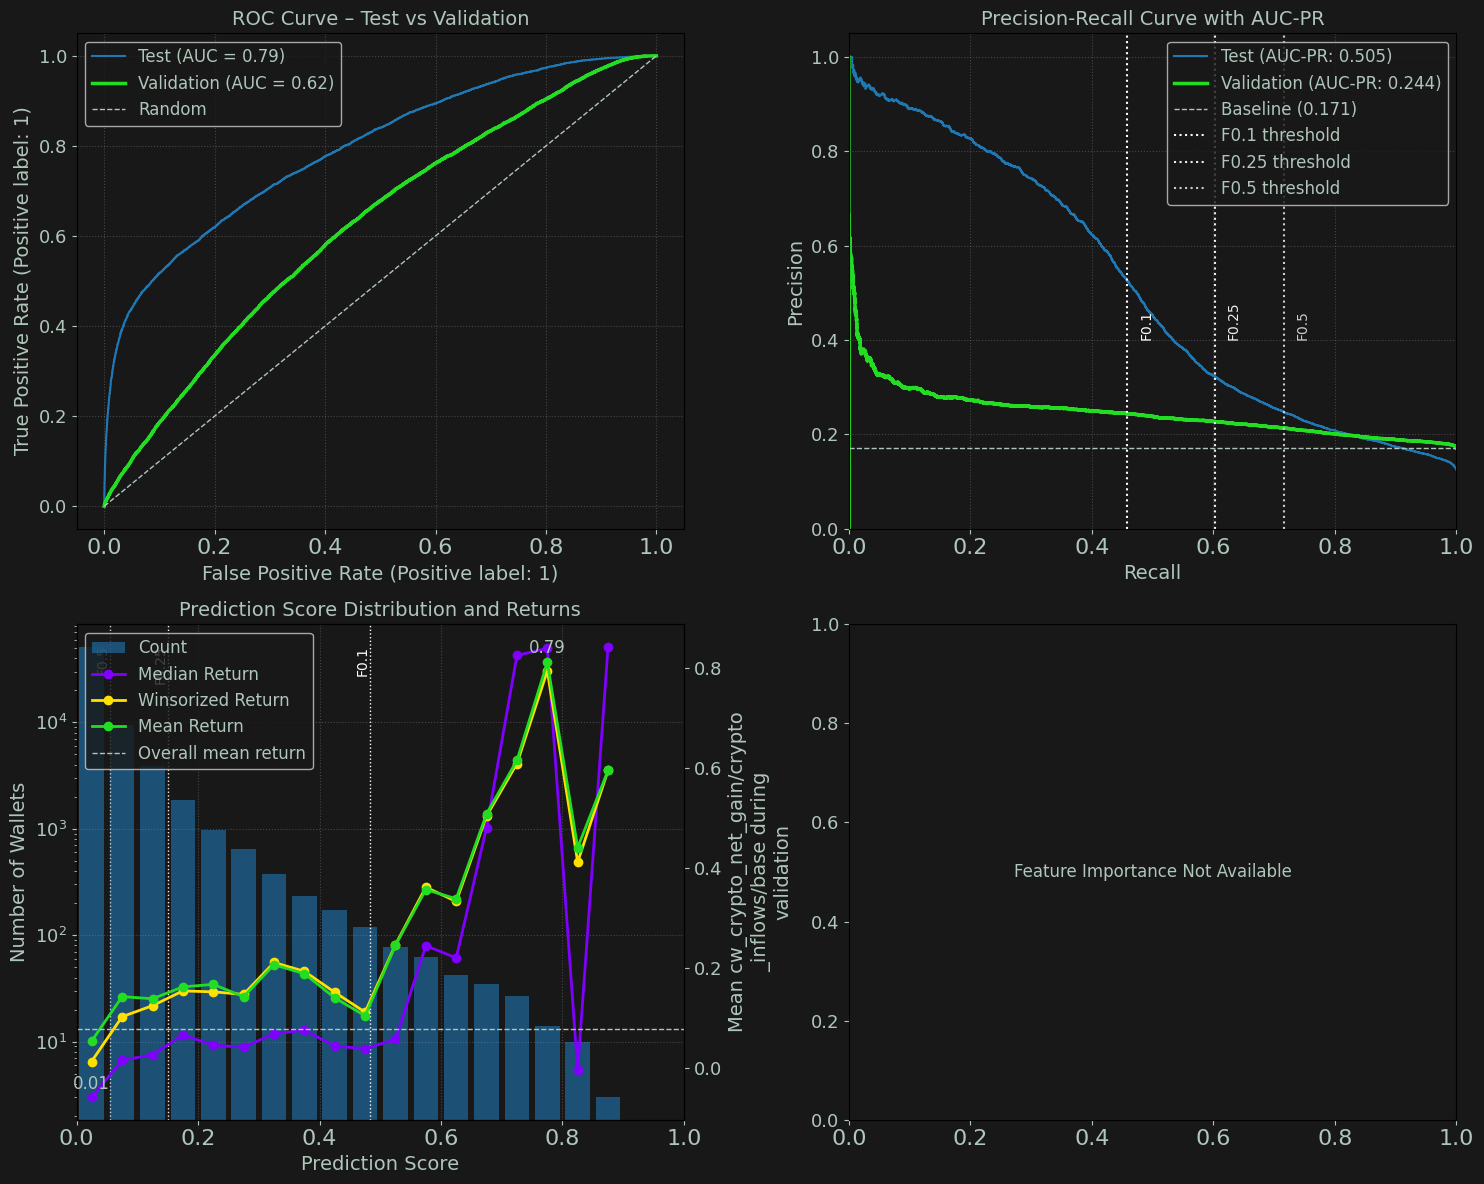

[15/Aug/25 17:26:34] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 17:26:34] WARNING [1138767417.<module>:5]                 120: 2024-10-02
[15/Aug/25 17:26:34] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 17:26:34] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh120/wscr-dda-956--sh120-0815-154648/output/model.tar.gz
Test Samples:             71,235
Val Positive Samples:     30,431 (29.3%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.531  |  0.748
Val Accuracy:               0.707  |  0.868
Val Precision:              0.303  |  0.511
Val Recall:                 0.001  |  0.379
Val F1 Score:               0.003  |  0.435

Validat

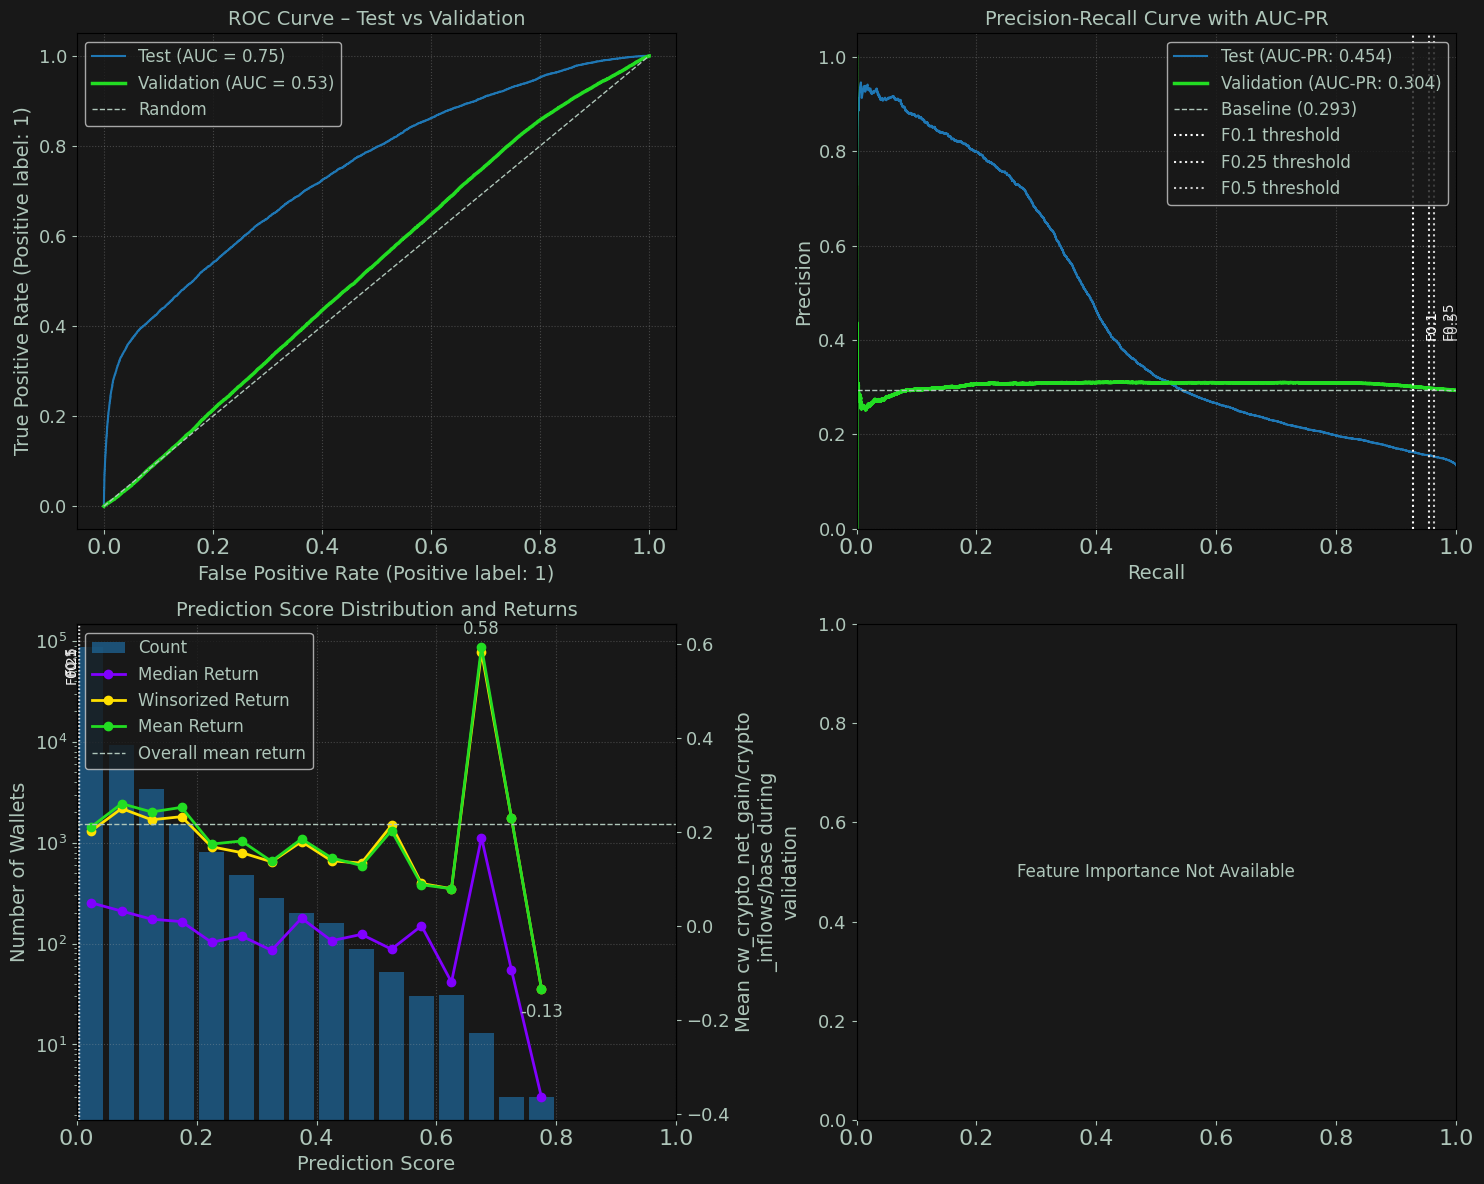

[15/Aug/25 17:26:34] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 17:26:34] WARNING [1138767417.<module>:5]                 180: 2024-12-01
[15/Aug/25 17:26:34] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 17:26:34] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh180/wscr-dda-956--sh180-0815-154648/output/model.tar.gz
Test Samples:             83,517
Val Positive Samples:     10,204 (8.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.568  |  0.684
Val Accuracy:               0.911  |  0.837
Val Precision:              0.132  |  0.519
Val Recall:                 0.018  |  0.312
Val F1 Score:               0.032  |  0.390

Validati

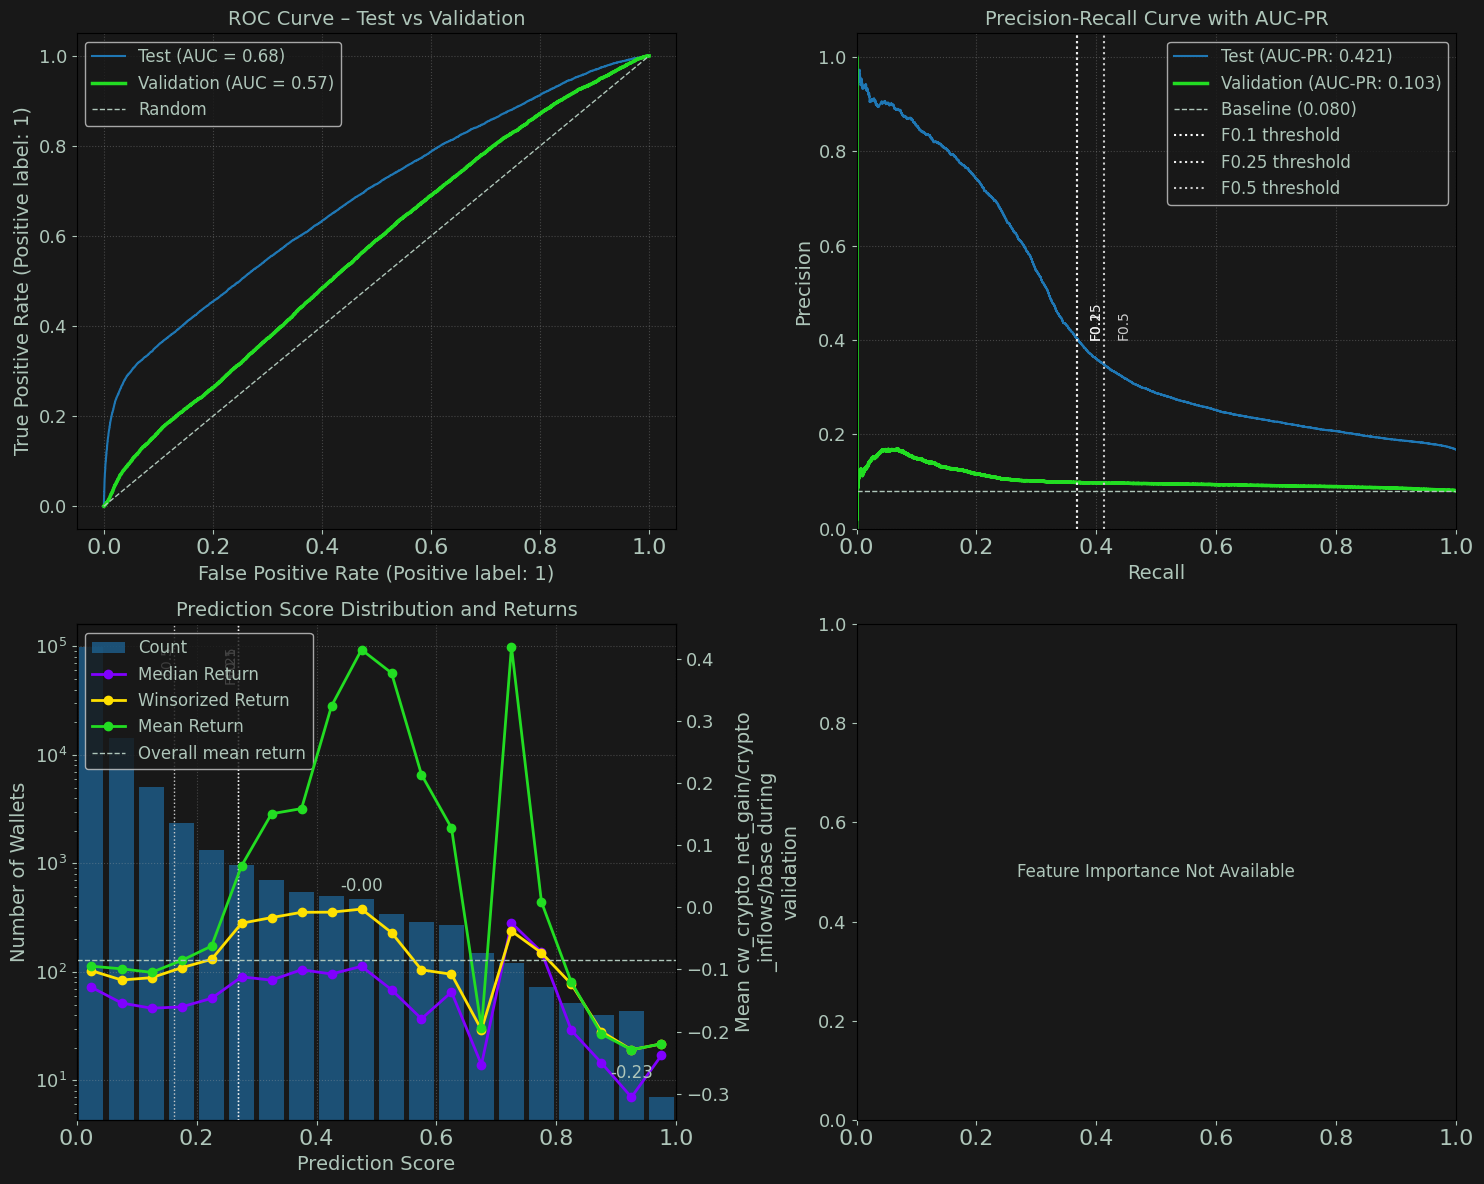

[15/Aug/25 17:26:34] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 17:26:34] WARNING [1138767417.<module>:5]                 240: 2025-01-30
[15/Aug/25 17:26:34] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 17:26:34] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh240/wscr-dda-956--sh240-0815-154648/output/model.tar.gz
Test Samples:             99,294
Val Positive Samples:     1,332 (1.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.526  |  0.736
Val Accuracy:               0.966  |  0.863
Val Precision:              0.023  |  0.572
Val Recall:                 0.020  |  0.340
Val F1 Score:               0.022  |  0.427

Validatio

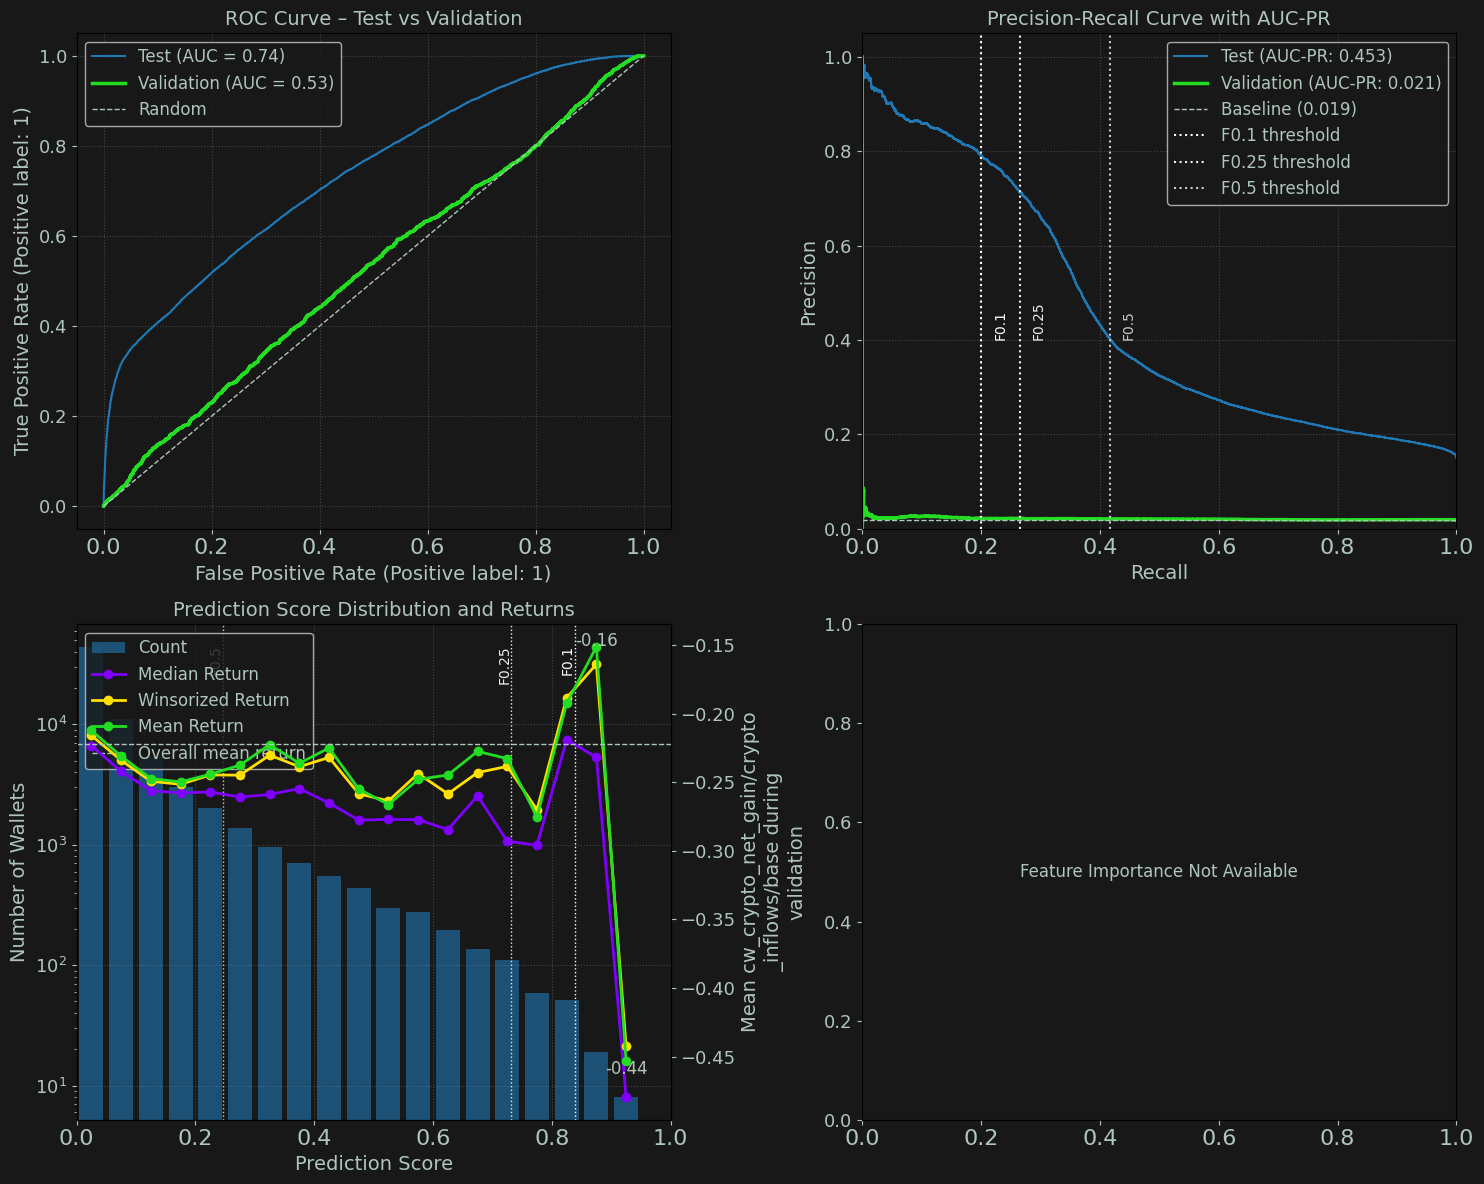

[15/Aug/25 17:26:35] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 17:26:35] WARNING [1138767417.<module>:5]                 300: 2025-03-31
[15/Aug/25 17:26:35] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 17:26:35] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh300/wscr-dda-956--sh300-0815-154648/output/model.tar.gz
Test Samples:             102,523
Val Positive Samples:     8,095 (18.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.558  |  0.743
Val Accuracy:               0.811  |  0.883
Val Precision:              0.379  |  0.636
Val Recall:                 0.034  |  0.309
Val F1 Score:               0.063  |  0.416

Validat

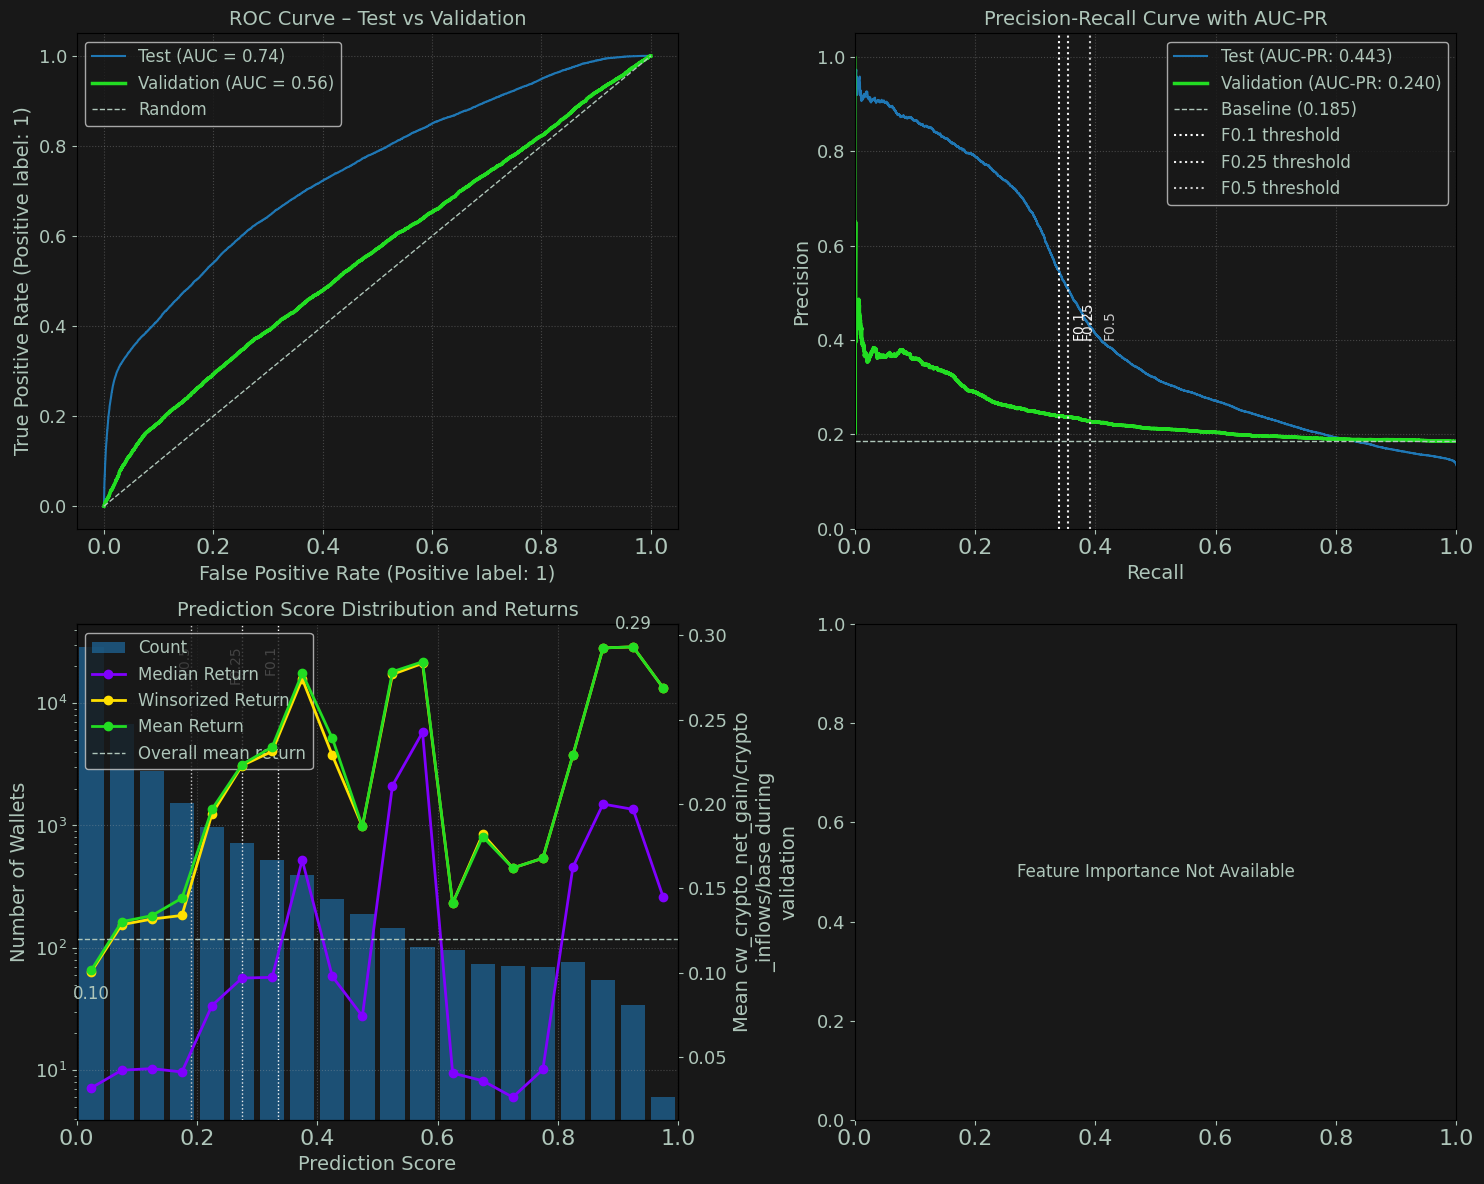

[15/Aug/25 17:26:35] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 17:26:35] WARNING [1138767417.<module>:5]                 360: 2025-05-30
[15/Aug/25 17:26:35] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 17:26:35] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh360/wscr-dda-956--sh360-0815-154648/output/model.tar.gz
Test Samples:             99,493
Val Positive Samples:     6,688 (15.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.584  |  0.743
Val Accuracy:               0.828  |  0.887
Val Precision:              0.263  |  0.594
Val Recall:                 0.062  |  0.318
Val F1 Score:               0.101  |  0.414

Validati

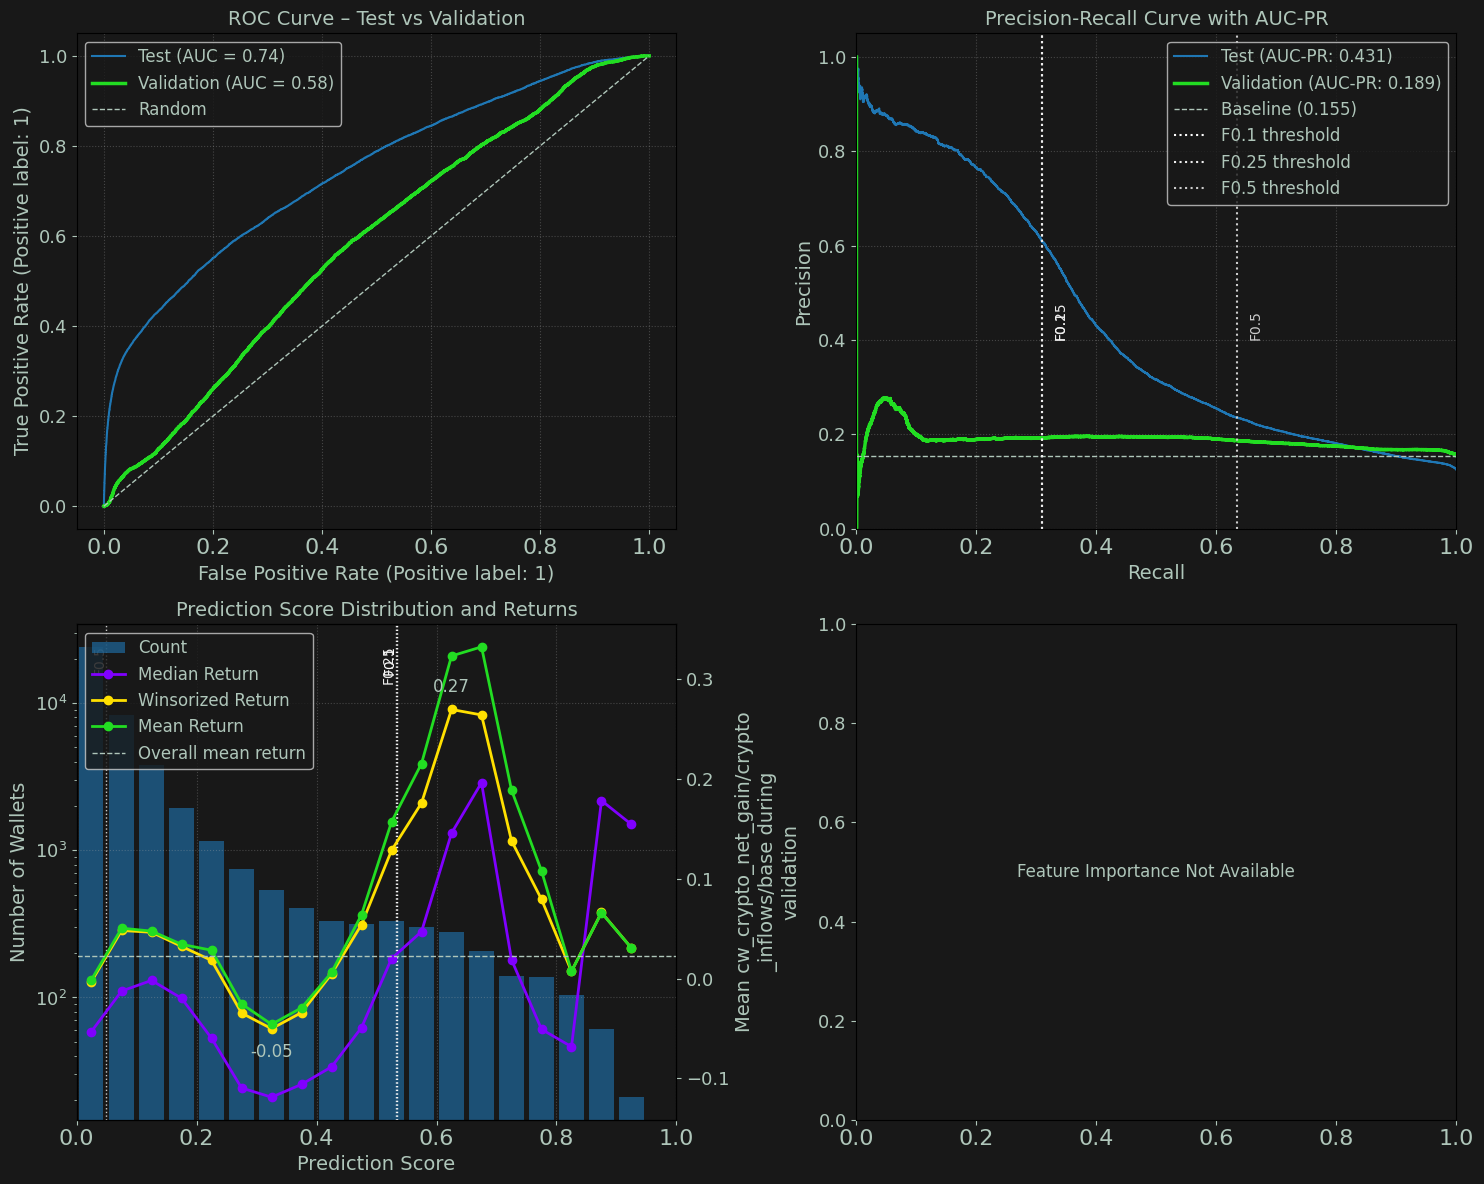

In [36]:
first_val_date = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
for e in evaluators:
    date = (first_val_date + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info('-------------------------------------------------')
    logger.warning(f'                {e}: {date}')
    logger.info('-------------------------------------------------')
    if evaluators[e] is None:
        logger.warning("All rows filtered out")
        continue
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


[15/Aug/25 16:23:14] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 16:23:14] WARNING [1138767417.<module>:5]                 0: 2024-05-05
[15/Aug/25 16:23:14] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 16:23:14] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh0/wscr-dda-956--sh0-0815-154648/output/model.tar.gz
Test Samples:             53,793
Val Positive Samples:     1,093 (2.2%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.538  |  0.788
Val Accuracy:               0.936  |  0.860
Val Precision:              0.016  |  0.517
Val Recall:                 0.033  |  0.478
Val F1 Score:               0.022  |  0.497

Validation Retu

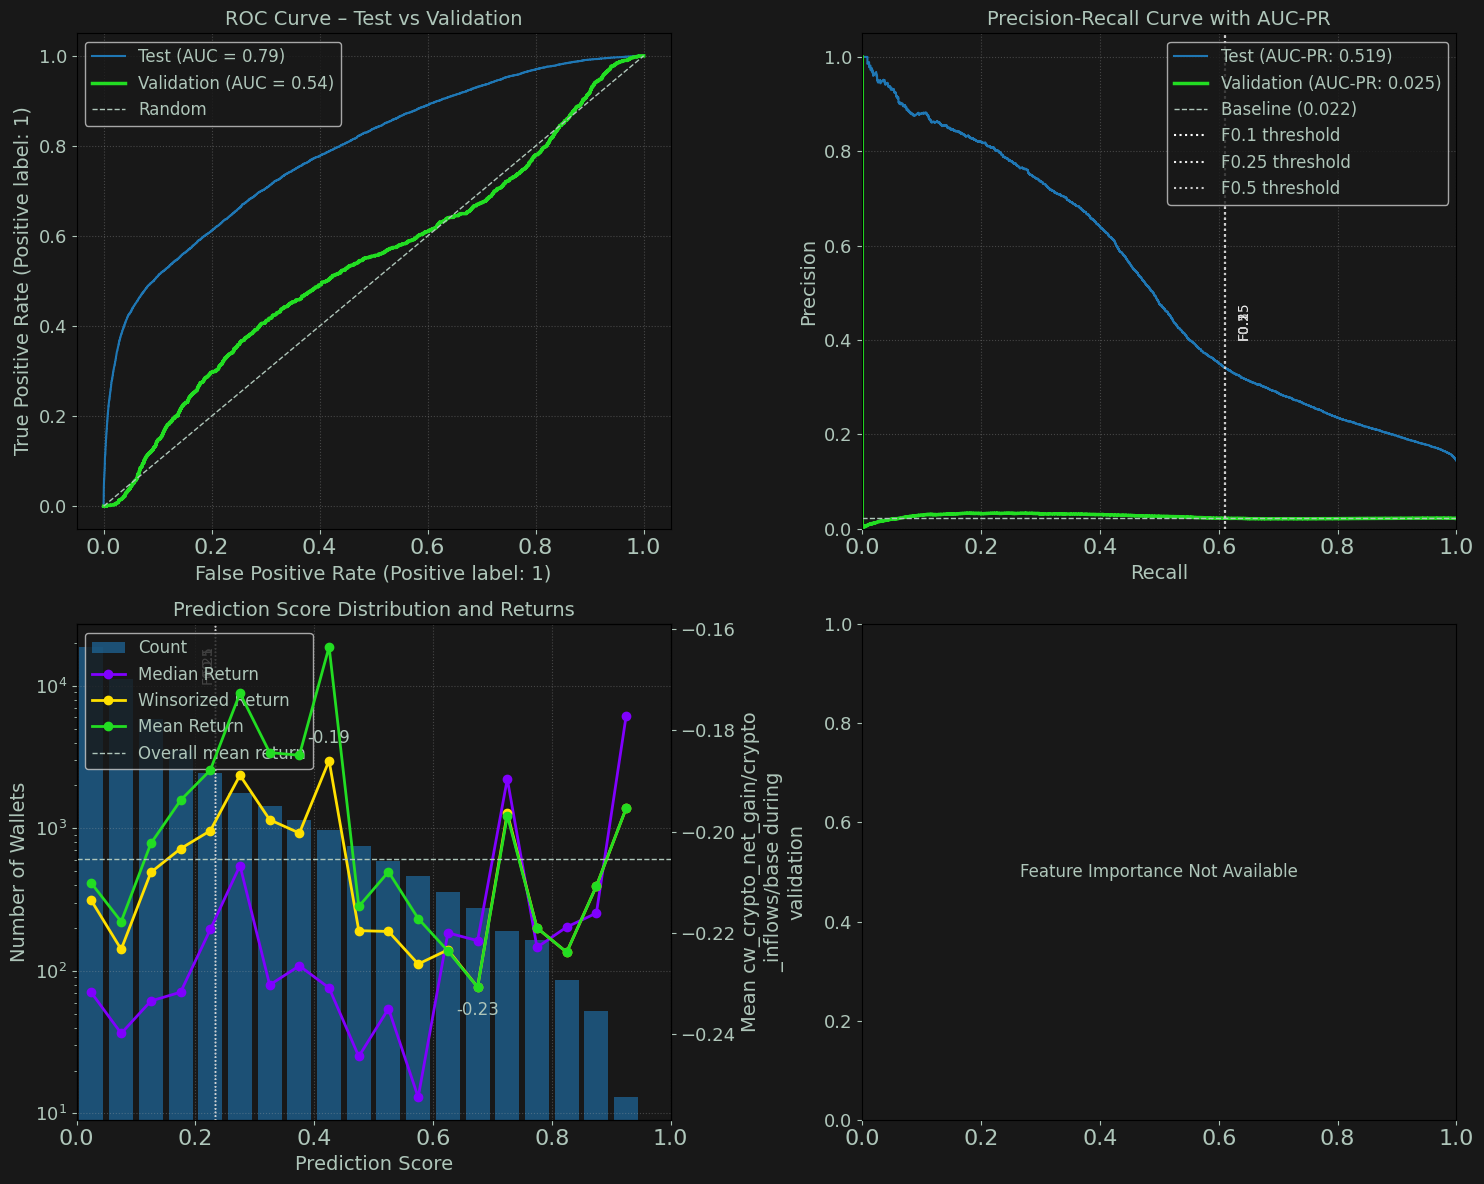

[15/Aug/25 16:23:14] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 16:23:14] WARNING [1138767417.<module>:5]                 60: 2024-07-04
[15/Aug/25 16:23:14] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 16:23:14] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh60/wscr-dda-956--sh60-0815-154648/output/model.tar.gz
Test Samples:             64,508
Val Positive Samples:     4,166 (5.2%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.566  |  0.792
Val Accuracy:               0.940  |  0.883
Val Precision:              0.029  |  0.536
Val Recall:                 0.005  |  0.451
Val F1 Score:               0.008  |  0.490

Validation R

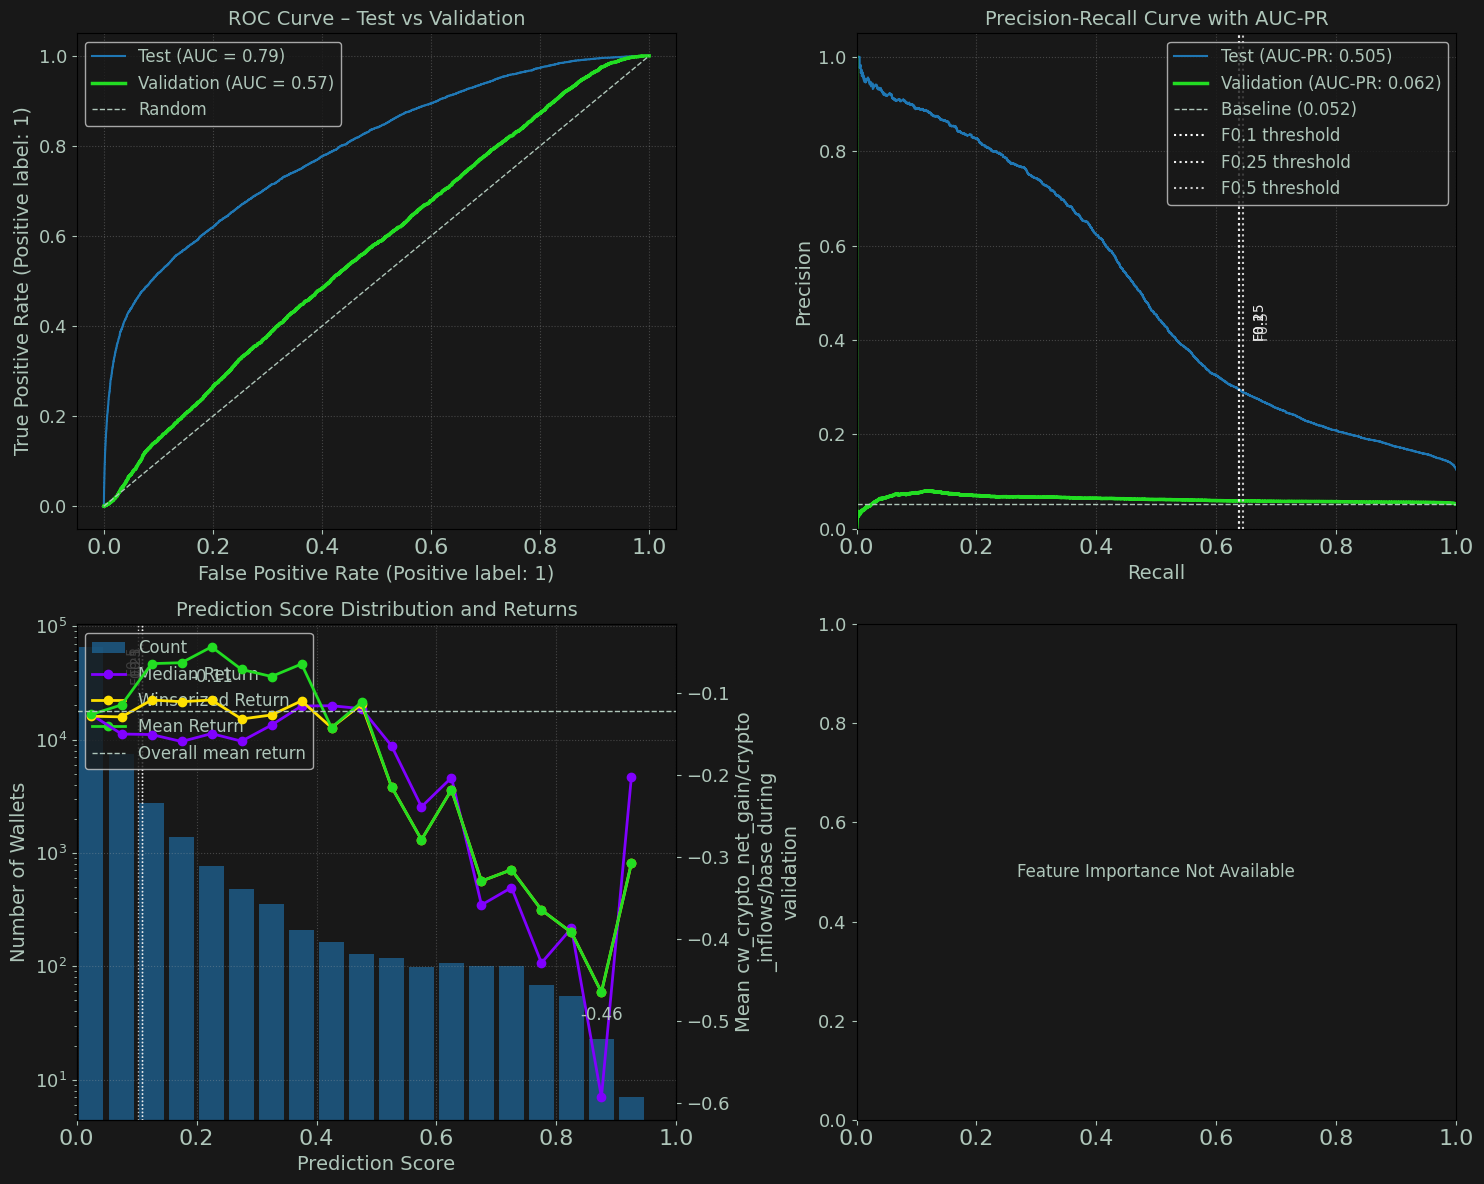

[15/Aug/25 16:23:15] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 16:23:15] WARNING [1138767417.<module>:5]                 120: 2024-09-02
[15/Aug/25 16:23:15] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 16:23:15] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh120/wscr-dda-956--sh120-0815-154648/output/model.tar.gz
Test Samples:             71,235
Val Positive Samples:     16,969 (21.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.548  |  0.748
Val Accuracy:               0.785  |  0.868
Val Precision:              0.317  |  0.511
Val Recall:                 0.002  |  0.379
Val F1 Score:               0.004  |  0.435

Validat

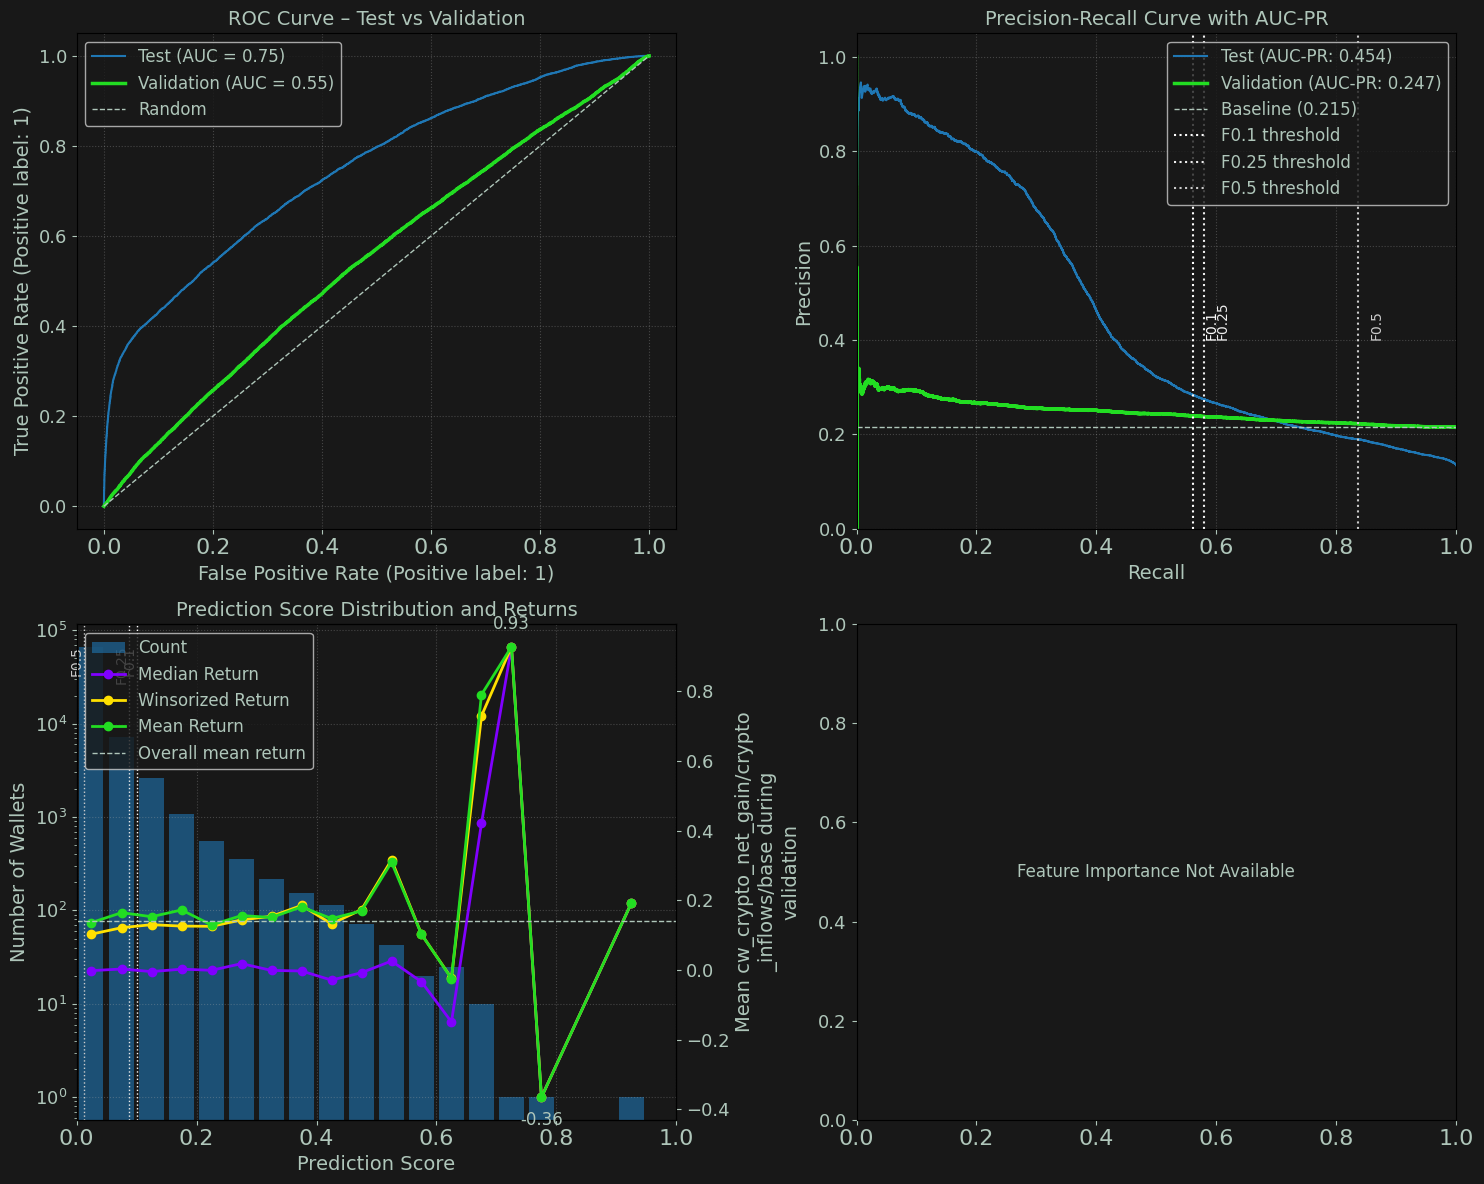

[15/Aug/25 16:23:15] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 16:23:15] WARNING [1138767417.<module>:5]                 180: 2024-11-01
[15/Aug/25 16:23:15] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 16:23:15] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh180/wscr-dda-956--sh180-0815-154648/output/model.tar.gz
Test Samples:             83,517
Val Positive Samples:     30,224 (24.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.479  |  0.684
Val Accuracy:               0.740  |  0.837
Val Precision:              0.076  |  0.519
Val Recall:                 0.004  |  0.312
Val F1 Score:               0.007  |  0.390

Validat

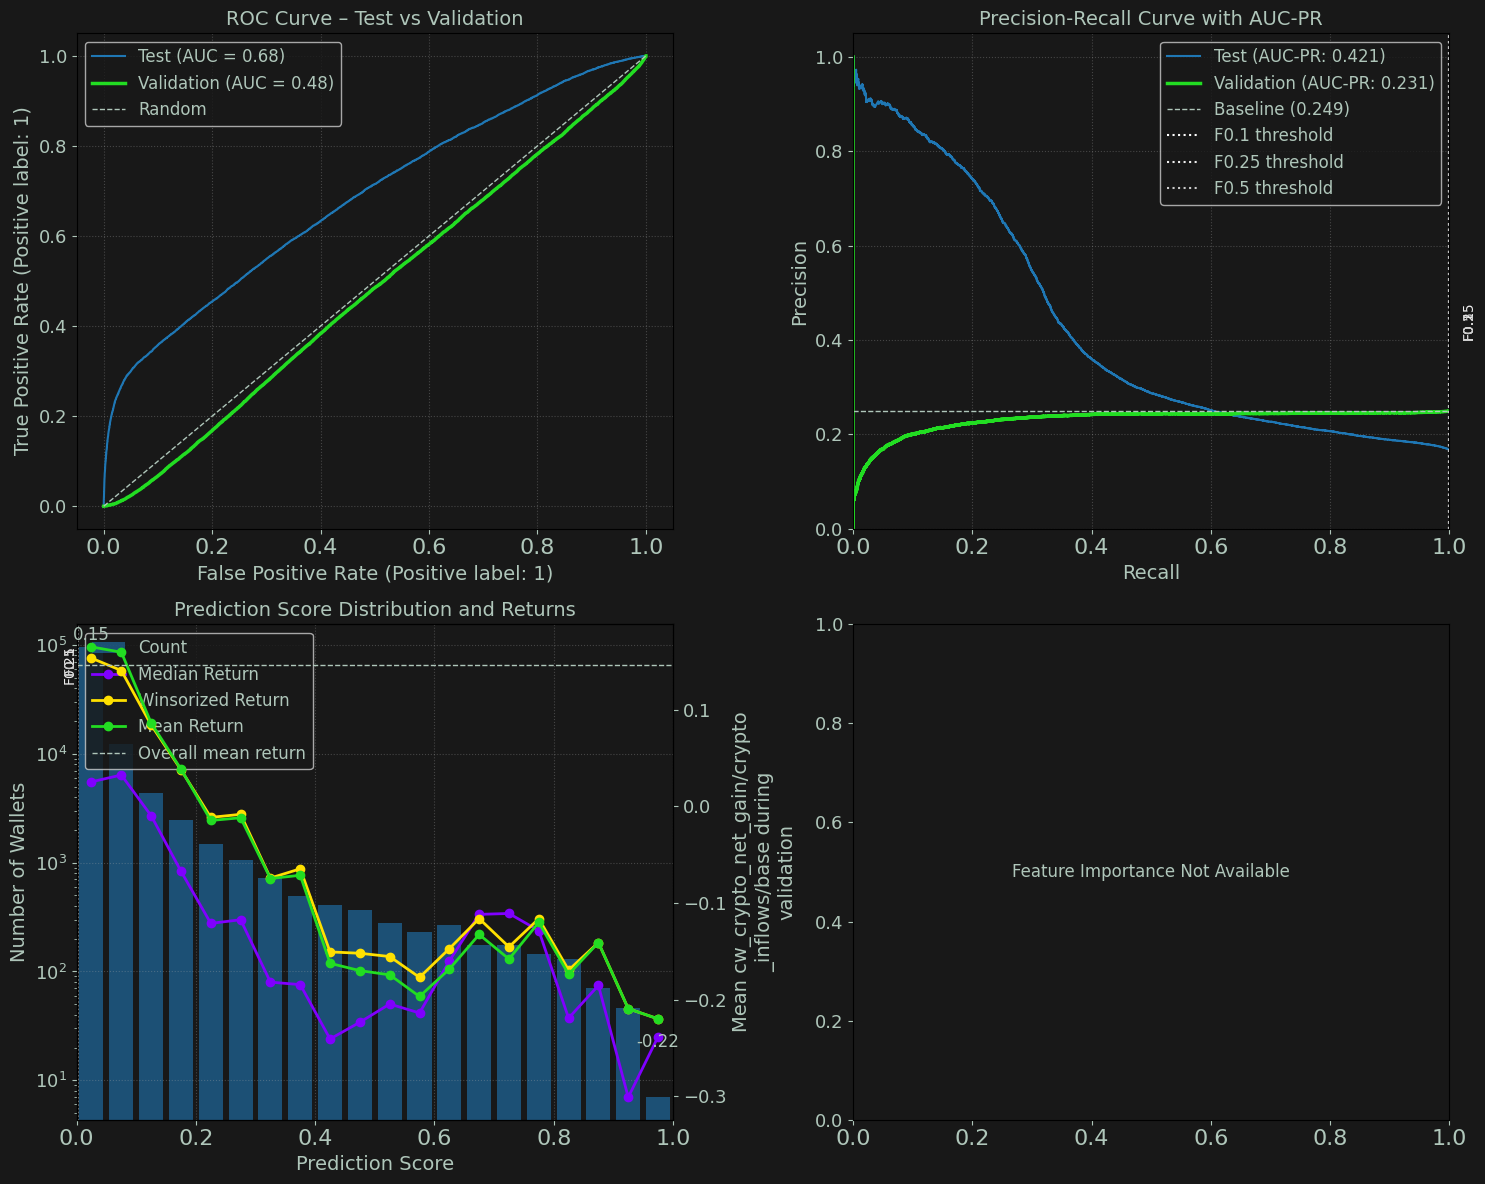

[15/Aug/25 16:23:16] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 16:23:16] WARNING [1138767417.<module>:5]                 240: 2024-12-31
[15/Aug/25 16:23:16] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 16:23:16] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh240/wscr-dda-956--sh240-0815-154648/output/model.tar.gz
Test Samples:             99,294
Val Positive Samples:     5,235 (4.9%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.602  |  0.736
Val Accuracy:               0.925  |  0.863
Val Precision:              0.085  |  0.572
Val Recall:                 0.056  |  0.340
Val F1 Score:               0.067  |  0.427

Validatio

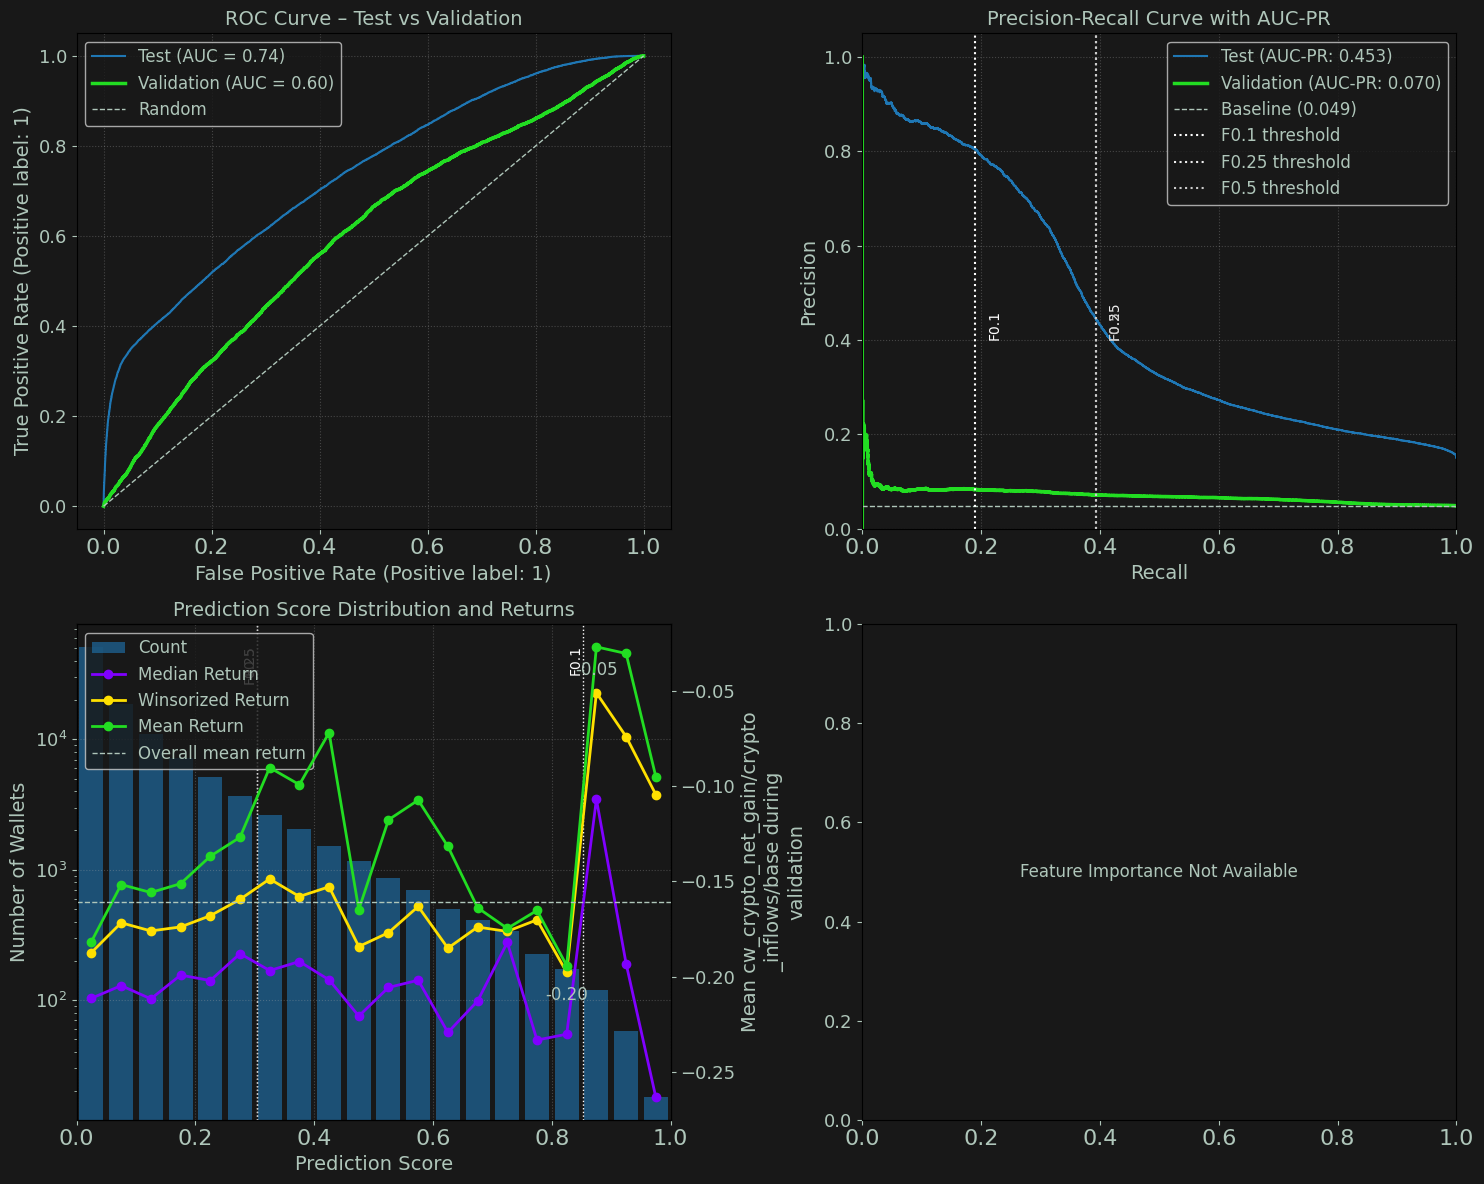

[15/Aug/25 16:23:16] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 16:23:16] WARNING [1138767417.<module>:5]                 300: 2025-03-01
[15/Aug/25 16:23:16] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 16:23:16] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh300/wscr-dda-956--sh300-0815-154648/output/model.tar.gz
Test Samples:             102,523
Val Positive Samples:     3,856 (8.0%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.682  |  0.743
Val Accuracy:               0.912  |  0.883
Val Precision:              0.212  |  0.636
Val Recall:                 0.036  |  0.309
Val F1 Score:               0.062  |  0.416

Validati

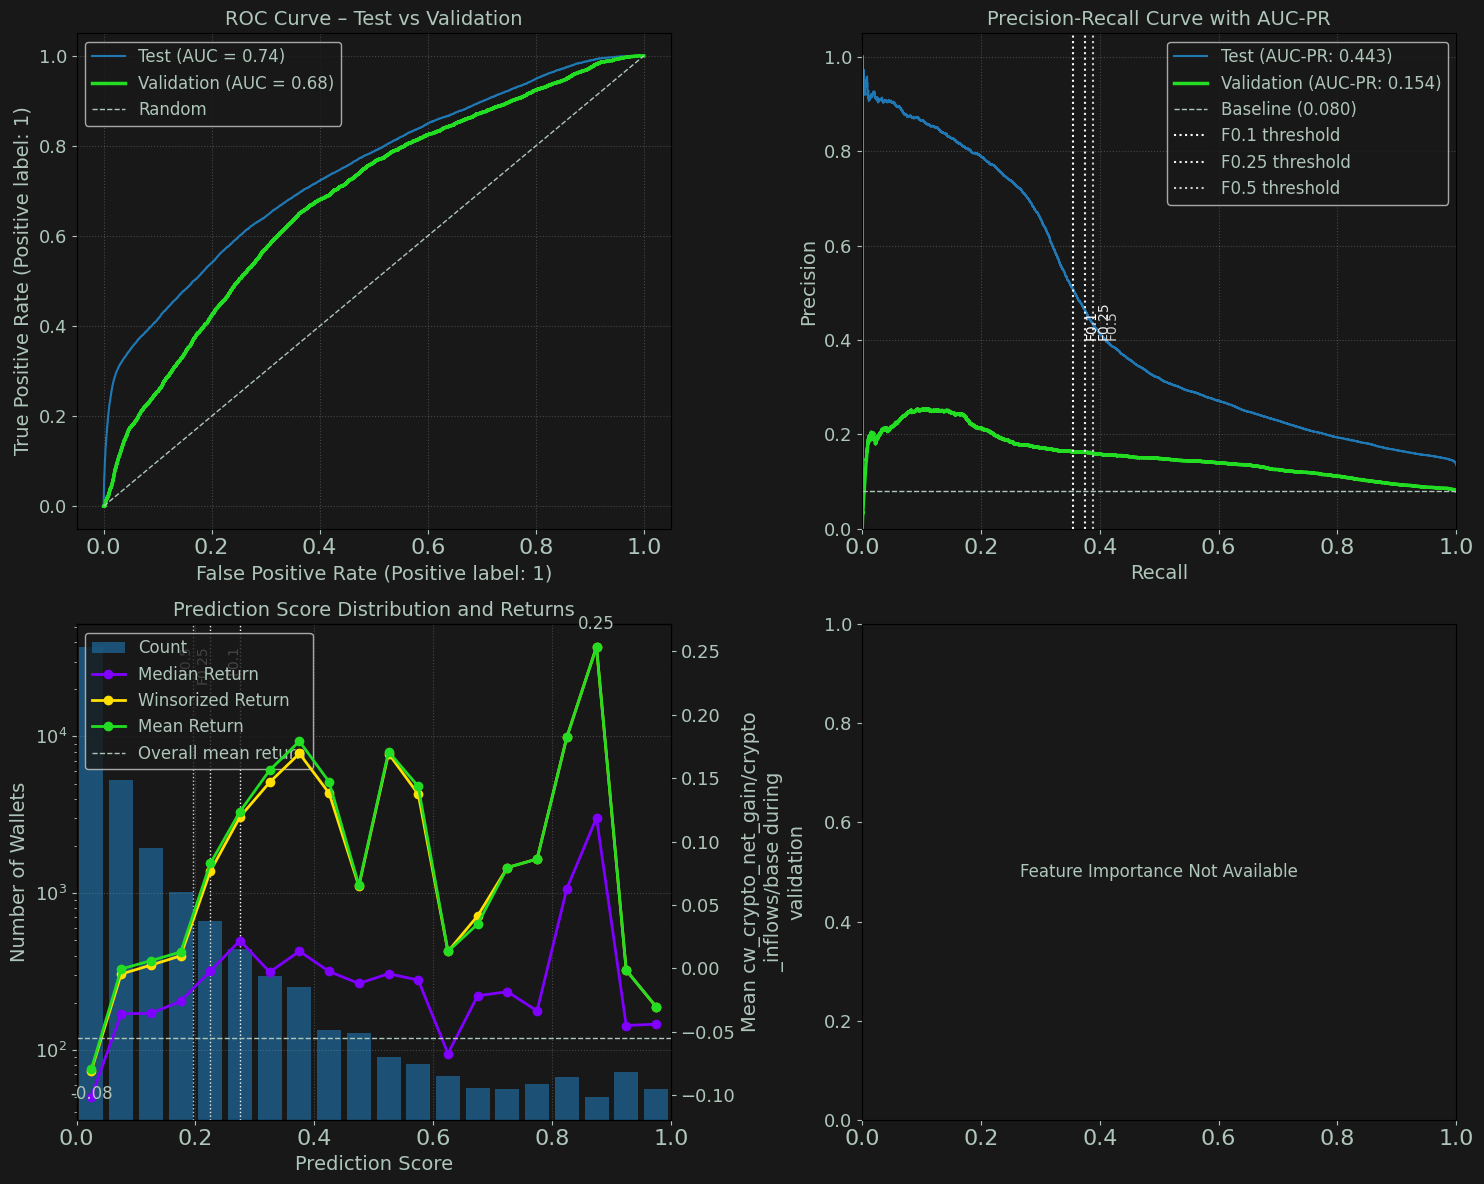

[15/Aug/25 16:23:16] INFO [1138767417.<module>:4] -------------------------------------------------
[15/Aug/25 16:23:16] WARNING [1138767417.<module>:5]                 360: 2025-04-30
[15/Aug/25 16:23:16] INFO [1138767417.<module>:6] -------------------------------------------------
[15/Aug/25 16:23:16] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: cw_crypto_net_gain/crypto_inflows/base 0.3 to 
ID: s3://wallet-script-models/model-outputs/dda-956-importan-v3/sh360/wscr-dda-956--sh360-0815-154648/output/model.tar.gz
Test Samples:             99,493
Val Positive Samples:     5,706 (12.5%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.645  |  0.743
Val Accuracy:               0.853  |  0.887
Val Precision:              0.260  |  0.594
Val Recall:                 0.091  |  0.318
Val F1 Score:               0.135  |  0.414

Validati

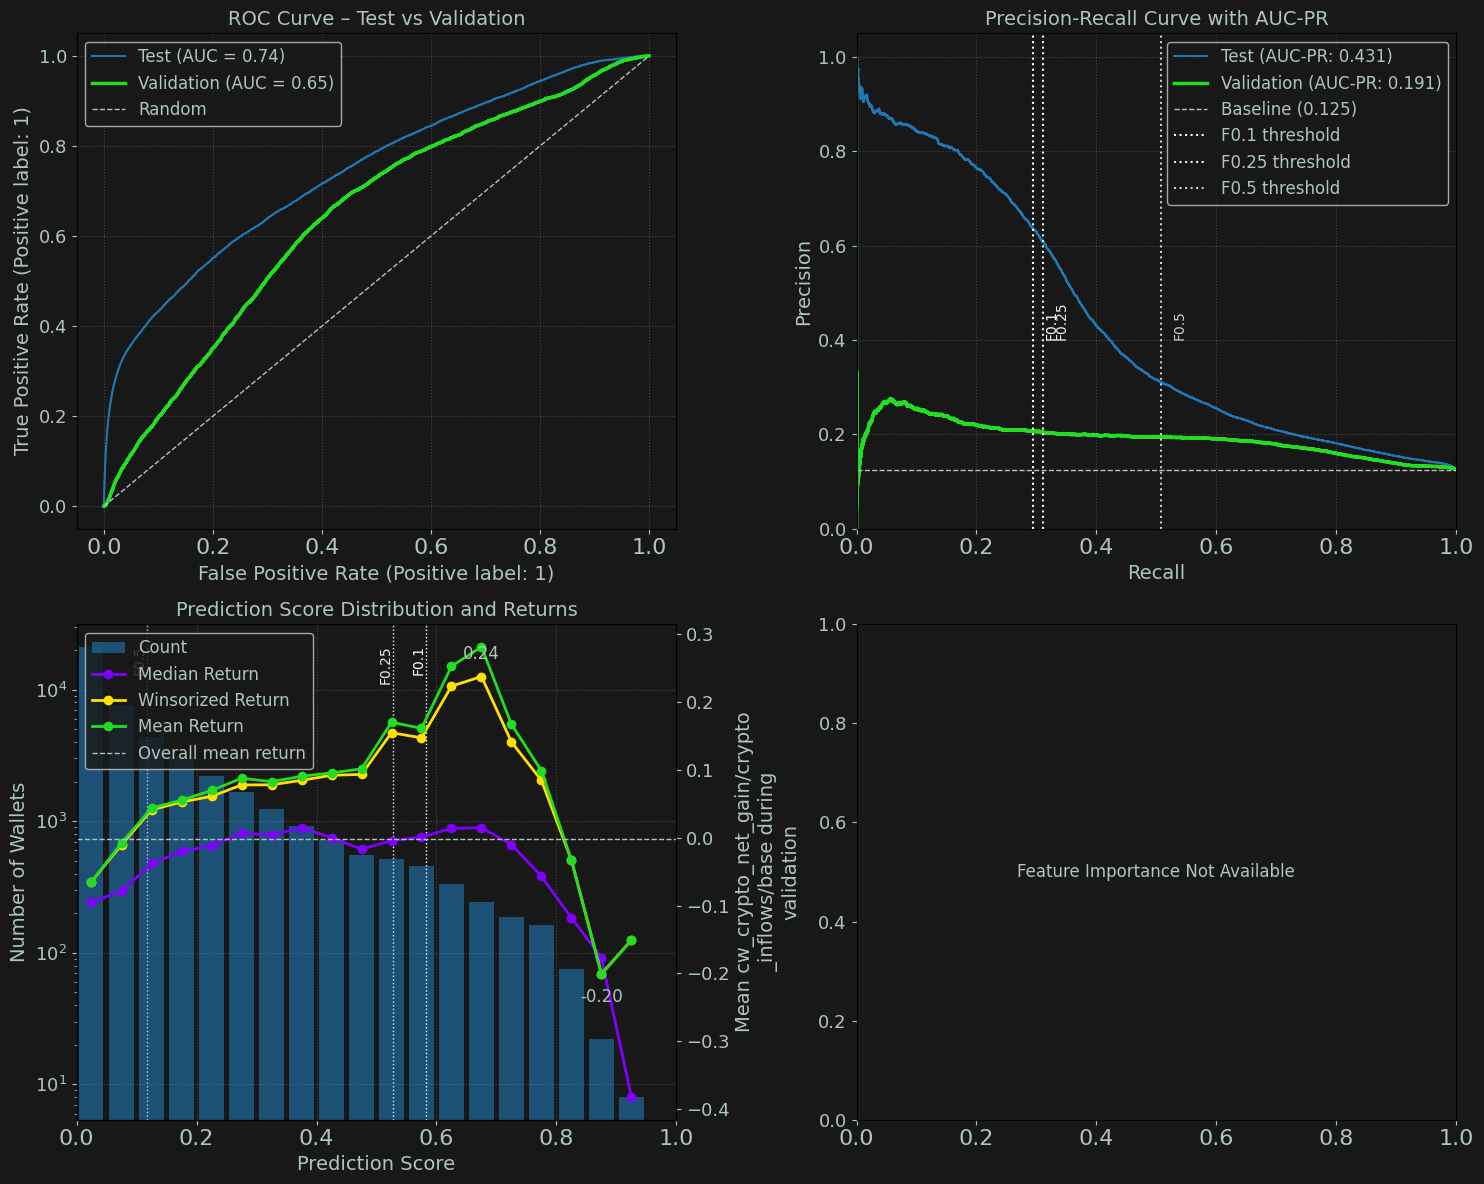

In [32]:
first_val_date = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
for e in evaluators:
    date = (first_val_date + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info('-------------------------------------------------')
    logger.warning(f'                {e}: {date}')
    logger.info('-------------------------------------------------')
    if evaluators[e] is None:
        logger.warning("All rows filtered out")
        continue
    evaluators[e].summary_report()
    evaluators[e].plot_wallet_evaluation()


#### predict and filter data by epoch_shift

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

# Create modeler with epoch_shift as the date_suffix
shift_s3_uris = {f'sh{epoch_shift}': s3_uris['concat']}
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix=f'sh{epoch_shift}',
    s3_uris=shift_s3_uris,
    override_approvals=None
)

# Load the existing concatenated model
model_info = concat_modeler.load_existing_model(epoch_shift=epoch_shift)

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

date_suffix = f'sh{epoch_shift}'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
    epoch_shift
)

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


### Single Model Sequence

#### train

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_concatenated_offsets_model(concat_uris)

#### evaluate HPO outcomes

In [ ]:
player = u.AmbientPlayer()
player.stop_all_players()

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.get_hpo_results('concat')

In [ ]:
# Get the best hyperparameters
best_params = modeling_results['tuner'].best_training_job()

# Or more detailed info
analytics = modeling_results['tuner'].analytics()
best_job_df = analytics.dataframe()

# The best parameters are in the hyperparameters columns
print(best_params)
print(best_job_df.loc[0, ['eta', 'max_depth', 'subsample', 'FinalObjectiveValue']])

#### load existing model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

# Create modeler with 'concat' as the date_suffix
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix='concat',
    s3_uris=s3_uris,
    override_approvals=None
)

# Step 2: Load the existing concatenated model
model_info = concat_modeler.load_existing_model(modeling_results['model_uri'])


In [ ]:
model_info

#### predict

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

pred_results = concat_modeler.batch_predict_test_and_val()

#### evaluate

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

date_suffix = 'concat'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
)

In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 mktcap 20M-4B
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, inflows $5k
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


## Temporal cv model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '241101',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

In [ ]:
sm.train_temporal_cv_script_model(sage_wallets_config,sage_wallets_modeling_config,cv_s3_uri)

### Predict Using Endpoints

#### deploy endpoint for predictions

In [ ]:
modeler.list_active_endpoints()

In [ ]:
modeler.deploy_endpoint()

#### load and preprocess test/val dfs

In [ ]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

#### predict

In [ ]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

#### delete all endpoints

In [ ]:
modeler.delete_all_endpoints()

In [ ]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

# Model Evaluation

### Analyze predictions

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    # '240306'
]
date_suffix = date_suffixes[0]

In [ ]:
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_val_pred = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)

In [ ]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    y_test_pred,
    y_val_pred
)

In [ ]:
evaluator.y_validation

In [ ]:
evaluator.y_validation_pred_proba

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(evaluator.y_validation, evaluator.y_validation_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()


In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [ ]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

In [ ]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

In [ ]:
target_variable